In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv('/SharedHDD/Code/ML/Recidivism Project/NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
train = train[(train['Recidivism_Arrest_Year1']==False) & (train['Recidivism_Arrest_Year2']==False)]
test = pd.read_csv('/SharedHDD/Code/ML/Recidivism Project/NIJ_s_Recidivism_Challenge_Test_Dataset3.csv')
train  = pd.concat([train[test.columns], train['Recidivism_Arrest_Year3']], axis =1)
train = pd.concat([train,test]).reset_index(drop=True)


for i in train.columns:
    if train[i].dtypes == 'object':
        train[i] = train[i].astype(str).str.replace(' or more', '').replace('nan', np.nan)


int_variables = ['Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',\
'Prior_Arrest_Episodes_Drug', 'Prior_Arrest_Episodes_PPViolationCharges', 'Prior_Conviction_Episodes_Felony',\
'Prior_Conviction_Episodes_Misd', 'Prior_Conviction_Episodes_Prop', 'Prior_Conviction_Episodes_Drug', 'Delinquency_Reports',\
                'Program_Attendances', 'Program_UnexcusedAbsences','Residence_Changes']
for i in int_variables:
    train[i] = train[i].astype('int')
    
bool_variables = [i for i in train.columns if train[i].dtypes == 'bool']


from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
nan_variables = ['Gang_Affiliated', 'Supervision_Risk_Score_First', 'Supervision_Level_First', 'Prison_Offense', \
                 'Recidivism_Arrest_Year3', 'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive','DrugTests_Cocaine_Positive', \
                 'DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year']
cat_var = ['Gender', 'Race', 'Age_at_Release','Residence_PUMA', 'Education_Level', 'Dependents', 'Prison_Years']


for i in cat_var + bool_variables:
    train[i] = labelencoder.fit_transform(train[i])

for i in nan_variables:
    train[nan_variables] = train[nan_variables].replace('nan', np.nan)

original = train[nan_variables]
mask = train[nan_variables].isnull()

for i in nan_variables:
    if train[i].dtypes == 'object':
        train[i] = labelencoder.fit_transform(train[i].astype('str'))

train[nan_variables] = train[nan_variables].where(~mask, original)

train[nan_variables] = train[nan_variables].astype('float')

for i in cat_var:
     train[i] = train[i].astype('category')
train['Recidivism_Arrest_Year3'] = train['Recidivism_Arrest_Year3'].astype('float')

In [2]:
%%time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import random
from optuna.samplers import TPESampler
import multiprocessing
import catboost as cat
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.utils import resample
from catboost import Pool
import sklearn.metrics

CPU times: user 992 ms, sys: 588 ms, total: 1.58 s
Wall time: 2.54 s


In [3]:
%%time
n_trials = int(100)
SEED = 123

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 17.9 µs


In [4]:
train_df = train[train['Recidivism_Arrest_Year3'].notnull()]
test_df = train[train['Recidivism_Arrest_Year3'].isnull()]
feats = [f for f in train_df.columns if f not in ['Recidivism_Arrest_Year3','ID']]




X = train_df[feats]
y  = train_df['Recidivism_Arrest_Year3']

In [5]:
cat_nums = [i for i in range(0,len(X.columns)) if (X.iloc[:,i].dtypes != 'int') & (X.iloc[:,i].dtypes != 'float')]

In [6]:
nan_variables = [i for i in nan_variables if i!= 'Recidivism_Arrest_Year3']

In [7]:
X.loc[:,nan_variables] = X.loc[:,nan_variables].astype(float)
X.loc[:,nan_variables] = X.loc[:,nan_variables].fillna(-1)
X.loc[:,nan_variables] = X.loc[:,nan_variables].astype(int)
X.loc[:,nan_variables] = X.loc[:,nan_variables].astype(str)
X.loc[:,nan_variables] = X.loc[:,nan_variables].replace('-1', 'nan')

In [10]:

def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)
    
    # Parameters
    params = {                        
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        #'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'eval_metric': 'Accuracy',
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        #"used_ram_limit": "3gb",
    }

    
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    # Learning
    model = cat.CatBoostClassifier(
        l2_leaf_reg=50,
        random_seed=SEED,
        border_count=64,
        n_estimators = 4000,
        **params
    )        
    model.fit(train_x, train_y, cat_features=cat_nums, eval_set=[(valid_x, valid_y)], verbose=200, early_stopping_rounds=500)
    # Predict
    
    y_pred = model.predict_proba(valid_x)[:,1]
    roc_auc = roc_auc_score(valid_y, y_pred)
    return roc_auc

In [12]:
%%time
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2021-08-25 16:03:27,116] A new study created in memory with name: no-name-caa3313e-3a6d-4ad2-9ae9-41da722ef6e4


0:	learn: 0.8113408	test: 0.8063830	best: 0.8063830 (0)	total: 13.8ms	remaining: 55s
200:	learn: 0.8488902	test: 0.8067376	best: 0.8099291 (169)	total: 731ms	remaining: 13.8s
400:	learn: 0.9198845	test: 0.8031915	best: 0.8099291 (169)	total: 1.43s	remaining: 12.9s
600:	learn: 0.9613864	test: 0.8003546	best: 0.8099291 (169)	total: 2.08s	remaining: 11.8s


[I 2021-08-25 16:03:29,598] Trial 0 finished with value: 0.6392741246728346 and parameters: {'depth': 9, 'learning_rate': 0.1648902268411761, 'random_strength': 94, 'od_type': 'IncToDec', 'colsample_bylevel': 0.04045539169327829, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.85621804419225}. Best is trial 0 with value: 0.6392741246728346.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.809929078
bestIteration = 169

Shrink model to first 170 iterations.
0:	learn: 0.8133171	test: 0.8003546	best: 0.8003546 (0)	total: 2.97ms	remaining: 11.9s
200:	learn: 0.8165096	test: 0.8010638	best: 0.8010638 (191)	total: 516ms	remaining: 9.75s
400:	learn: 0.8309517	test: 0.7968085	best: 0.8017730 (206)	total: 1.24s	remaining: 11.2s
600:	learn: 0.8403770	test: 0.7964539	best: 0.8017730 (206)	total: 1.9s	remaining: 10.7s


[I 2021-08-25 16:03:31,940] Trial 1 finished with value: 0.6645093102886539 and parameters: {'depth': 10, 'learning_rate': 0.2395495078126601, 'random_strength': 37, 'od_type': 'Iter', 'colsample_bylevel': 0.020762325707282706, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.6645093102886539.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8017730496
bestIteration = 206

Shrink model to first 207 iterations.
0:	learn: 0.8131651	test: 0.8024823	best: 0.8024823 (0)	total: 14.7ms	remaining: 58.9s
200:	learn: 0.8131651	test: 0.8028369	best: 0.8031915 (187)	total: 2.25s	remaining: 42.5s
400:	learn: 0.8286713	test: 0.8024823	best: 0.8042553 (322)	total: 6.28s	remaining: 56.4s
600:	learn: 0.8475220	test: 0.8014184	best: 0.8042553 (322)	total: 10.2s	remaining: 57.6s
800:	learn: 0.8621161	test: 0.7989362	best: 0.8042553 (322)	total: 14.3s	remaining: 57s


[I 2021-08-25 16:03:46,776] Trial 2 finished with value: 0.6682594322371203 and parameters: {'depth': 9, 'learning_rate': 0.06856837540823599, 'random_strength': 70, 'od_type': 'IncToDec', 'colsample_bylevel': 0.09454686391598882, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.6682594322371203.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8042553191
bestIteration = 322

Shrink model to first 323 iterations.
0:	learn: 0.8107327	test: 0.8063830	best: 0.8063830 (0)	total: 4.86ms	remaining: 19.4s
200:	learn: 0.8107327	test: 0.8063830	best: 0.8063830 (0)	total: 712ms	remaining: 13.5s
400:	learn: 0.8107327	test: 0.8063830	best: 0.8063830 (0)	total: 1.35s	remaining: 12.1s


[I 2021-08-25 16:03:48,579] Trial 3 finished with value: 0.591492537073012 and parameters: {'depth': 4, 'learning_rate': 0.015605006708060466, 'random_strength': 1, 'od_type': 'IncToDec', 'colsample_bylevel': 0.07220156133856241, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.374048825483414}. Best is trial 2 with value: 0.6682594322371203.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8063829787
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8101247	test: 0.8078014	best: 0.8078014 (0)	total: 2.87ms	remaining: 11.5s
200:	learn: 0.8108848	test: 0.8078014	best: 0.8081560 (194)	total: 979ms	remaining: 18.5s
400:	learn: 0.8192460	test: 0.8092199	best: 0.8095745 (381)	total: 2.13s	remaining: 19.1s
600:	learn: 0.8311037	test: 0.8070922	best: 0.8102837 (403)	total: 3.32s	remaining: 18.8s
800:	learn: 0.8402250	test: 0.8056738	best: 0.8102837 (403)	total: 4.46s	remaining: 17.8s


[I 2021-08-25 16:03:53,847] Trial 4 finished with value: 0.6795847655579277 and parameters: {'depth': 7, 'learning_rate': 0.06563492865841733, 'random_strength': 64, 'od_type': 'Iter', 'colsample_bylevel': 0.06606154267083032, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 0.6795847655579277.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8102836879
bestIteration = 403

Shrink model to first 404 iterations.
0:	learn: 0.8060201	test: 0.8173759	best: 0.8173759 (0)	total: 3.7ms	remaining: 14.8s
200:	learn: 0.9300699	test: 0.8109929	best: 0.8173759 (0)	total: 1.42s	remaining: 26.8s
400:	learn: 0.9957434	test: 0.8099291	best: 0.8173759 (0)	total: 2.93s	remaining: 26.3s


[I 2021-08-25 16:03:57,722] Trial 5 finished with value: 0.5403314870585262 and parameters: {'depth': 10, 'learning_rate': 0.1781270794945021, 'random_strength': 14, 'od_type': 'Iter', 'colsample_bylevel': 0.08162807180045173, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.812388901750588}. Best is trial 4 with value: 0.6795847655579277.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8173758865
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8075403	test: 0.8138298	best: 0.8138298 (0)	total: 4.75ms	remaining: 19s
200:	learn: 0.8075403	test: 0.8138298	best: 0.8138298 (0)	total: 646ms	remaining: 12.2s
400:	learn: 0.8075403	test: 0.8138298	best: 0.8138298 (0)	total: 1.26s	remaining: 11.4s


[I 2021-08-25 16:03:59,468] Trial 6 finished with value: 0.5591152609191825 and parameters: {'depth': 4, 'learning_rate': 0.02596625640791654, 'random_strength': 79, 'od_type': 'Iter', 'colsample_bylevel': 0.07439700602545131, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 0.6795847655579277.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8138297872
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8034357	test: 0.8234043	best: 0.8234043 (0)	total: 2.7ms	remaining: 10.8s
200:	learn: 0.8136212	test: 0.8237589	best: 0.8241135 (150)	total: 497ms	remaining: 9.4s
400:	learn: 0.8376406	test: 0.8209220	best: 0.8241135 (150)	total: 1.05s	remaining: 9.41s


[I 2021-08-25 16:04:01,240] Trial 7 finished with value: 0.6649120167145759 and parameters: {'depth': 7, 'learning_rate': 0.13819095856092267, 'random_strength': 67, 'od_type': 'IncToDec', 'colsample_bylevel': 0.03259831472369065, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.693350747686361}. Best is trial 4 with value: 0.6795847655579277.


600:	learn: 0.8578595	test: 0.8184397	best: 0.8241135 (150)	total: 1.52s	remaining: 8.63s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8241134752
bestIteration = 150

Shrink model to first 151 iterations.
0:	learn: 0.8089085	test: 0.8109929	best: 0.8109929 (0)	total: 12.1ms	remaining: 48.2s
200:	learn: 0.8394649	test: 0.8056738	best: 0.8120567 (77)	total: 687ms	remaining: 13s
400:	learn: 0.8961690	test: 0.8017730	best: 0.8120567 (77)	total: 1.42s	remaining: 12.8s


[I 2021-08-25 16:04:03,405] Trial 8 finished with value: 0.6756198465755133 and parameters: {'depth': 6, 'learning_rate': 0.19337586471751958, 'random_strength': 42, 'od_type': 'Iter', 'colsample_bylevel': 0.08153962261735195, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 0.6795847655579277.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8120567376
bestIteration = 77

Shrink model to first 78 iterations.
0:	learn: 0.8099726	test: 0.8092199	best: 0.8092199 (0)	total: 33ms	remaining: 2m 11s
200:	learn: 0.8052600	test: 0.8191489	best: 0.8191489 (2)	total: 3.48s	remaining: 1m 5s
400:	learn: 0.8063241	test: 0.8191489	best: 0.8191489 (2)	total: 6.48s	remaining: 58.2s


[I 2021-08-25 16:04:11,705] Trial 9 finished with value: 0.6187645361174773 and parameters: {'depth': 9, 'learning_rate': 0.024305780844462846, 'random_strength': 15, 'od_type': 'Iter', 'colsample_bylevel': 0.07347902765999782, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.1211072452090844}. Best is trial 4 with value: 0.6795847655579277.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8191489362
bestIteration = 2

Shrink model to first 3 iterations.
0:	learn: 0.8067802	test: 0.8156028	best: 0.8156028 (0)	total: 3.94ms	remaining: 15.8s
200:	learn: 0.8067802	test: 0.8156028	best: 0.8156028 (0)	total: 707ms	remaining: 13.4s
400:	learn: 0.8117969	test: 0.8141844	best: 0.8163121 (260)	total: 1.49s	remaining: 13.4s
600:	learn: 0.8178778	test: 0.8138298	best: 0.8163121 (260)	total: 2.29s	remaining: 13s


[I 2021-08-25 16:04:14,825] Trial 10 finished with value: 0.6856153846153847 and parameters: {'depth': 6, 'learning_rate': 0.06635933240226112, 'random_strength': 97, 'od_type': 'Iter', 'colsample_bylevel': 0.05293550394470139, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.15081724157518023}. Best is trial 10 with value: 0.6856153846153847.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8163120567
bestIteration = 260

Shrink model to first 261 iterations.
0:	learn: 0.8087565	test: 0.8113475	best: 0.8113475 (0)	total: 5.56ms	remaining: 22.2s
200:	learn: 0.8090605	test: 0.8109929	best: 0.8113475 (0)	total: 691ms	remaining: 13.1s
400:	learn: 0.8125570	test: 0.8117021	best: 0.8120567 (372)	total: 1.46s	remaining: 13.1s
600:	learn: 0.8209182	test: 0.8127660	best: 0.8131206 (553)	total: 2.25s	remaining: 12.7s
800:	learn: 0.8329279	test: 0.8117021	best: 0.8138298 (698)	total: 3.05s	remaining: 12.2s
1000:	learn: 0.8415932	test: 0.8099291	best: 0.8138298 (698)	total: 3.87s	remaining: 11.6s


[I 2021-08-25 16:04:19,710] Trial 11 finished with value: 0.6601367382617382 and parameters: {'depth': 6, 'learning_rate': 0.07046870410509527, 'random_strength': 98, 'od_type': 'Iter', 'colsample_bylevel': 0.055010147609373984, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11210223553880644}. Best is trial 10 with value: 0.6856153846153847.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8138297872
bestIteration = 698

Shrink model to first 699 iterations.
0:	learn: 0.8107327	test: 0.8063830	best: 0.8063830 (0)	total: 4.01ms	remaining: 16s
200:	learn: 0.8107327	test: 0.8063830	best: 0.8063830 (0)	total: 784ms	remaining: 14.8s
400:	learn: 0.8113408	test: 0.8063830	best: 0.8063830 (0)	total: 1.67s	remaining: 15s


[I 2021-08-25 16:04:22,042] Trial 12 finished with value: 0.5459059410246745 and parameters: {'depth': 7, 'learning_rate': 0.04403257242238583, 'random_strength': 57, 'od_type': 'Iter', 'colsample_bylevel': 0.05364263953861764, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1375503686240762}. Best is trial 10 with value: 0.6856153846153847.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8063829787
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8107327	test: 0.8060284	best: 0.8060284 (0)	total: 6.1ms	remaining: 24.4s
200:	learn: 0.8122530	test: 0.8078014	best: 0.8078014 (167)	total: 763ms	remaining: 14.4s
400:	learn: 0.8204621	test: 0.8056738	best: 0.8085106 (303)	total: 1.59s	remaining: 14.2s
600:	learn: 0.8311037	test: 0.8039007	best: 0.8085106 (303)	total: 2.43s	remaining: 13.8s


[I 2021-08-25 16:04:25,509] Trial 13 finished with value: 0.6891985100279128 and parameters: {'depth': 6, 'learning_rate': 0.09636712275998431, 'random_strength': 86, 'od_type': 'Iter', 'colsample_bylevel': 0.05478990171144061, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.445066838996252}. Best is trial 13 with value: 0.6891985100279128.


800:	learn: 0.8456978	test: 0.8035461	best: 0.8085106 (303)	total: 3.29s	remaining: 13.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8085106383
bestIteration = 303

Shrink model to first 304 iterations.
0:	learn: 0.8105807	test: 0.8067376	best: 0.8067376 (0)	total: 3.57ms	remaining: 14.3s
200:	learn: 0.8116449	test: 0.8060284	best: 0.8067376 (0)	total: 663ms	remaining: 12.5s
400:	learn: 0.8204621	test: 0.8060284	best: 0.8067376 (0)	total: 1.31s	remaining: 11.8s


[I 2021-08-25 16:04:27,293] Trial 14 finished with value: 0.5459364855328158 and parameters: {'depth': 5, 'learning_rate': 0.10575547019513316, 'random_strength': 87, 'od_type': 'Iter', 'colsample_bylevel': 0.047638329711917816, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4167770973648519}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8067375887
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8111888	test: 0.8053191	best: 0.8053191 (0)	total: 2.75ms	remaining: 11s
200:	learn: 0.8111888	test: 0.8053191	best: 0.8053191 (0)	total: 496ms	remaining: 9.38s
400:	learn: 0.8114929	test: 0.8053191	best: 0.8053191 (0)	total: 1.03s	remaining: 9.25s


[I 2021-08-25 16:04:28,734] Trial 15 finished with value: 0.541774043354917 and parameters: {'depth': 6, 'learning_rate': 0.04145872275553715, 'random_strength': 99, 'od_type': 'Iter', 'colsample_bylevel': 0.027520784850006235, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.43203410599919356}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8053191489
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8105807	test: 0.8067376	best: 0.8067376 (0)	total: 2.15ms	remaining: 8.62s
200:	learn: 0.8105807	test: 0.8067376	best: 0.8067376 (0)	total: 382ms	remaining: 7.22s
400:	learn: 0.8105807	test: 0.8067376	best: 0.8067376 (0)	total: 763ms	remaining: 6.85s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8067375887
bestIteration = 0

Shrink model to first 1 iterations.


[I 2021-08-25 16:04:29,812] Trial 16 finished with value: 0.5 and parameters: {'depth': 5, 'learning_rate': 0.10575446882900894, 'random_strength': 85, 'od_type': 'Iter', 'colsample_bylevel': 0.010782090420905173, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.681703300555697}. Best is trial 13 with value: 0.6891985100279128.


0:	learn: 0.8101247	test: 0.8078014	best: 0.8078014 (0)	total: 3.77ms	remaining: 15.1s
200:	learn: 0.8628763	test: 0.7996454	best: 0.8085106 (23)	total: 1.49s	remaining: 28.1s
400:	learn: 0.9224688	test: 0.7921986	best: 0.8085106 (23)	total: 3.06s	remaining: 27.5s


[I 2021-08-25 16:04:33,961] Trial 17 finished with value: 0.6497275398566101 and parameters: {'depth': 8, 'learning_rate': 0.2889827158713912, 'random_strength': 78, 'od_type': 'Iter', 'colsample_bylevel': 0.0591954193086223, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.28766911031417464}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8085106383
bestIteration = 23

Shrink model to first 24 iterations.
0:	learn: 0.8043478	test: 0.8212766	best: 0.8212766 (0)	total: 4.45ms	remaining: 17.8s
200:	learn: 0.8067802	test: 0.8216312	best: 0.8219858 (156)	total: 572ms	remaining: 10.8s
400:	learn: 0.8105807	test: 0.8202128	best: 0.8219858 (156)	total: 1.19s	remaining: 10.7s
600:	learn: 0.8154454	test: 0.8173759	best: 0.8219858 (156)	total: 1.81s	remaining: 10.3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8219858156
bestIteration = 156

Shrink model to first 157 iterations.


[I 2021-08-25 16:04:36,095] Trial 18 finished with value: 0.6701011939030075 and parameters: {'depth': 5, 'learning_rate': 0.09543614230102275, 'random_strength': 99, 'od_type': 'Iter', 'colsample_bylevel': 0.042713149154510896, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6079064044551099}. Best is trial 13 with value: 0.6891985100279128.


0:	learn: 0.8101247	test: 0.8081560	best: 0.8081560 (0)	total: 5.79ms	remaining: 23.1s
200:	learn: 0.8099726	test: 0.8081560	best: 0.8081560 (0)	total: 751ms	remaining: 14.2s
400:	learn: 0.8105807	test: 0.8081560	best: 0.8081560 (0)	total: 1.49s	remaining: 13.4s
600:	learn: 0.8121009	test: 0.8074468	best: 0.8085106 (426)	total: 2.38s	remaining: 13.4s
800:	learn: 0.8152934	test: 0.8063830	best: 0.8085106 (426)	total: 3.33s	remaining: 13.3s


[I 2021-08-25 16:04:40,206] Trial 19 finished with value: 0.656959508945698 and parameters: {'depth': 6, 'learning_rate': 0.03569780948369701, 'random_strength': 53, 'od_type': 'Iter', 'colsample_bylevel': 0.06106299600502256, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2695619431305381}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8085106383
bestIteration = 426

Shrink model to first 427 iterations.
0:	learn: 0.8095166	test: 0.8113475	best: 0.8113475 (0)	total: 11.9ms	remaining: 47.7s
200:	learn: 0.8086044	test: 0.8113475	best: 0.8113475 (0)	total: 1.66s	remaining: 31.3s
400:	learn: 0.8171177	test: 0.8109929	best: 0.8117021 (249)	total: 3.52s	remaining: 31.6s
600:	learn: 0.8288234	test: 0.8095745	best: 0.8117021 (249)	total: 6.05s	remaining: 34.2s


[I 2021-08-25 16:04:48,321] Trial 20 finished with value: 0.6759383708396867 and parameters: {'depth': 8, 'learning_rate': 0.0522865066493811, 'random_strength': 88, 'od_type': 'IncToDec', 'colsample_bylevel': 0.09691344164859789, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9333444348636866}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8117021277
bestIteration = 249

Shrink model to first 250 iterations.
0:	learn: 0.8090605	test: 0.8102837	best: 0.8102837 (0)	total: 2.95ms	remaining: 11.8s
200:	learn: 0.8092125	test: 0.8106383	best: 0.8106383 (198)	total: 975ms	remaining: 18.4s
400:	learn: 0.8189419	test: 0.8106383	best: 0.8124113 (287)	total: 2.14s	remaining: 19.2s
600:	learn: 0.8289754	test: 0.8106383	best: 0.8124113 (287)	total: 3.31s	remaining: 18.7s


[I 2021-08-25 16:04:52,917] Trial 21 finished with value: 0.6844917073968793 and parameters: {'depth': 7, 'learning_rate': 0.07389432016019348, 'random_strength': 65, 'od_type': 'Iter', 'colsample_bylevel': 0.06371754005755456, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8124113475
bestIteration = 287

Shrink model to first 288 iterations.
0:	learn: 0.8066282	test: 0.8159574	best: 0.8159574 (0)	total: 3.12ms	remaining: 12.5s
200:	learn: 0.8093645	test: 0.8152482	best: 0.8159574 (0)	total: 1.17s	remaining: 22s
400:	learn: 0.8216783	test: 0.8124113	best: 0.8159574 (0)	total: 2.58s	remaining: 23.1s


[I 2021-08-25 16:04:56,227] Trial 22 finished with value: 0.5569254885410464 and parameters: {'depth': 8, 'learning_rate': 0.09138525392807233, 'random_strength': 73, 'od_type': 'Iter', 'colsample_bylevel': 0.049628219384354626, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8159574468
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8089085	test: 0.8106383	best: 0.8106383 (0)	total: 3.35ms	remaining: 13.4s
200:	learn: 0.8146853	test: 0.8095745	best: 0.8117021 (130)	total: 864ms	remaining: 16.3s
400:	learn: 0.8318638	test: 0.8106383	best: 0.8117021 (130)	total: 1.82s	remaining: 16.3s


[I 2021-08-25 16:04:59,227] Trial 23 finished with value: 0.6756998305923371 and parameters: {'depth': 6, 'learning_rate': 0.13393627567915942, 'random_strength': 44, 'od_type': 'Iter', 'colsample_bylevel': 0.06437329689588585, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


600:	learn: 0.8487382	test: 0.8078014	best: 0.8117021 (130)	total: 2.72s	remaining: 15.4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8117021277
bestIteration = 130

Shrink model to first 131 iterations.
0:	learn: 0.8114929	test: 0.8046099	best: 0.8046099 (0)	total: 4.36ms	remaining: 17.4s
200:	learn: 0.8119489	test: 0.8042553	best: 0.8046099 (0)	total: 562ms	remaining: 10.6s
400:	learn: 0.8157495	test: 0.8042553	best: 0.8049645 (296)	total: 1.12s	remaining: 10.1s
600:	learn: 0.8219824	test: 0.8035461	best: 0.8049645 (296)	total: 1.7s	remaining: 9.63s
800:	learn: 0.8253268	test: 0.8021277	best: 0.8053191 (670)	total: 2.29s	remaining: 9.14s
1000:	learn: 0.8307996	test: 0.8010638	best: 0.8053191 (670)	total: 2.85s	remaining: 8.53s


[I 2021-08-25 16:05:02,736] Trial 24 finished with value: 0.6553163885687228 and parameters: {'depth': 5, 'learning_rate': 0.07943749765907253, 'random_strength': 62, 'od_type': 'Iter', 'colsample_bylevel': 0.039966724192482594, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.45291505614203026}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8053191489
bestIteration = 670

Shrink model to first 671 iterations.
0:	learn: 0.8114929	test: 0.8049645	best: 0.8049645 (0)	total: 9.75ms	remaining: 39s
200:	learn: 0.8110368	test: 0.8056738	best: 0.8056738 (1)	total: 871ms	remaining: 16.5s
400:	learn: 0.8160535	test: 0.8067376	best: 0.8067376 (360)	total: 1.9s	remaining: 17s
600:	learn: 0.8280632	test: 0.8046099	best: 0.8070922 (459)	total: 3.11s	remaining: 17.6s
800:	learn: 0.8399209	test: 0.8035461	best: 0.8070922 (459)	total: 4.28s	remaining: 17.1s


[I 2021-08-25 16:05:08,198] Trial 25 finished with value: 0.6537416790891333 and parameters: {'depth': 7, 'learning_rate': 0.05506653789797236, 'random_strength': 81, 'od_type': 'Iter', 'colsample_bylevel': 0.06722138840455277, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24083375386773723}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8070921986
bestIteration = 459

Shrink model to first 460 iterations.
0:	learn: 0.8086044	test: 0.8113475	best: 0.8113475 (0)	total: 2.85ms	remaining: 11.4s
200:	learn: 0.8086044	test: 0.8113475	best: 0.8113475 (0)	total: 837ms	remaining: 15.8s
400:	learn: 0.8087565	test: 0.8113475	best: 0.8113475 (0)	total: 1.77s	remaining: 15.9s


[I 2021-08-25 16:05:10,616] Trial 26 finished with value: 0.5 and parameters: {'depth': 6, 'learning_rate': 0.03419814037999142, 'random_strength': 90, 'od_type': 'Iter', 'colsample_bylevel': 0.08497184785853582, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8113475177
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8125570	test: 0.8021277	best: 0.8021277 (0)	total: 4.38ms	remaining: 17.5s
200:	learn: 0.8127090	test: 0.8021277	best: 0.8021277 (0)	total: 594ms	remaining: 11.2s
400:	learn: 0.8218303	test: 0.8028369	best: 0.8031915 (366)	total: 1.24s	remaining: 11.2s
600:	learn: 0.8508665	test: 0.8028369	best: 0.8039007 (461)	total: 1.93s	remaining: 10.9s
800:	learn: 0.8846154	test: 0.8031915	best: 0.8039007 (461)	total: 2.62s	remaining: 10.4s


[I 2021-08-25 16:05:14,048] Trial 27 finished with value: 0.664738281534722 and parameters: {'depth': 8, 'learning_rate': 0.05324336361940728, 'random_strength': 75, 'od_type': 'Iter', 'colsample_bylevel': 0.05637534586855373, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.10783397577180381}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8039007092
bestIteration = 461

Shrink model to first 462 iterations.
0:	learn: 0.8093645	test: 0.8095745	best: 0.8095745 (0)	total: 2.92ms	remaining: 11.7s
200:	learn: 0.8127090	test: 0.8088652	best: 0.8106383 (135)	total: 906ms	remaining: 17.1s
400:	learn: 0.8291274	test: 0.8081560	best: 0.8106383 (135)	total: 1.95s	remaining: 17.5s
600:	learn: 0.8447856	test: 0.8053191	best: 0.8106383 (135)	total: 2.85s	remaining: 16.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8106382979
bestIteration = 135

Shrink model to first 136 iterations.


[I 2021-08-25 16:05:17,199] Trial 28 finished with value: 0.6840838812663594 and parameters: {'depth': 7, 'learning_rate': 0.12287711321026173, 'random_strength': 32, 'od_type': 'Iter', 'colsample_bylevel': 0.04863201298715872, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


0:	learn: 0.8125570	test: 0.8021277	best: 0.8021277 (0)	total: 2.97ms	remaining: 11.9s
200:	learn: 0.8127090	test: 0.8021277	best: 0.8021277 (0)	total: 467ms	remaining: 8.83s
400:	learn: 0.8155974	test: 0.8031915	best: 0.8031915 (328)	total: 947ms	remaining: 8.5s
600:	learn: 0.8212223	test: 0.8021277	best: 0.8031915 (328)	total: 1.46s	remaining: 8.28s


[I 2021-08-25 16:05:19,341] Trial 29 finished with value: 0.6647501655844259 and parameters: {'depth': 5, 'learning_rate': 0.08231781131360813, 'random_strength': 94, 'od_type': 'IncToDec', 'colsample_bylevel': 0.037555613397928844, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.0389765131409234}. Best is trial 13 with value: 0.6891985100279128.


800:	learn: 0.8283673	test: 0.8017730	best: 0.8031915 (328)	total: 1.93s	remaining: 7.71s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8031914894
bestIteration = 328

Shrink model to first 329 iterations.
0:	learn: 0.8159015	test: 0.7943262	best: 0.7943262 (0)	total: 6.35ms	remaining: 25.4s
200:	learn: 0.8159015	test: 0.7943262	best: 0.7943262 (0)	total: 674ms	remaining: 12.7s
400:	learn: 0.8159015	test: 0.7943262	best: 0.7943262 (0)	total: 1.31s	remaining: 11.8s


[I 2021-08-25 16:05:21,127] Trial 30 finished with value: 0.5745039254926109 and parameters: {'depth': 6, 'learning_rate': 0.025652327414710723, 'random_strength': 56, 'od_type': 'Iter', 'colsample_bylevel': 0.04336118658507697, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5250491749919116}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7943262411
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8089085	test: 0.8106383	best: 0.8106383 (0)	total: 3ms	remaining: 12s
200:	learn: 0.8169656	test: 0.8102837	best: 0.8124113 (171)	total: 979ms	remaining: 18.5s
400:	learn: 0.8390088	test: 0.8095745	best: 0.8124113 (171)	total: 2s	remaining: 18s
600:	learn: 0.8537549	test: 0.8085106	best: 0.8124113 (171)	total: 3s	remaining: 17s


[I 2021-08-25 16:05:24,632] Trial 31 finished with value: 0.6674440741723764 and parameters: {'depth': 7, 'learning_rate': 0.1304214442313311, 'random_strength': 33, 'od_type': 'Iter', 'colsample_bylevel': 0.0491051320122215, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8124113475
bestIteration = 171

Shrink model to first 172 iterations.
0:	learn: 0.8127090	test: 0.8017730	best: 0.8017730 (0)	total: 3.22ms	remaining: 12.9s
200:	learn: 0.8175737	test: 0.8010638	best: 0.8031915 (135)	total: 878ms	remaining: 16.6s
400:	learn: 0.8391608	test: 0.8003546	best: 0.8031915 (135)	total: 2.05s	remaining: 18.4s
600:	learn: 0.8540590	test: 0.7950355	best: 0.8031915 (135)	total: 3.08s	remaining: 17.4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8031914894
bestIteration = 135

Shrink model to first 136 iterations.


[I 2021-08-25 16:05:28,064] Trial 32 finished with value: 0.6736867423741928 and parameters: {'depth': 7, 'learning_rate': 0.12106929854609215, 'random_strength': 29, 'od_type': 'Iter', 'colsample_bylevel': 0.05155578073009396, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


0:	learn: 0.8063241	test: 0.8166667	best: 0.8166667 (0)	total: 3.47ms	remaining: 13.9s
200:	learn: 0.8379447	test: 0.8095745	best: 0.8166667 (0)	total: 1.67s	remaining: 31.6s
400:	learn: 0.8695652	test: 0.8035461	best: 0.8166667 (0)	total: 3.27s	remaining: 29.3s


[I 2021-08-25 16:05:32,193] Trial 33 finished with value: 0.5706785615600206 and parameters: {'depth': 8, 'learning_rate': 0.21847878121676498, 'random_strength': 19, 'od_type': 'Iter', 'colsample_bylevel': 0.0599542631703289, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8166666667
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8101247	test: 0.8078014	best: 0.8078014 (0)	total: 3.38ms	remaining: 13.5s
200:	learn: 0.8102767	test: 0.8074468	best: 0.8078014 (0)	total: 699ms	remaining: 13.2s
400:	learn: 0.8149894	test: 0.8049645	best: 0.8078014 (0)	total: 1.56s	remaining: 14s


[I 2021-08-25 16:05:34,322] Trial 34 finished with value: 0.566823198960699 and parameters: {'depth': 7, 'learning_rate': 0.06317199750521287, 'random_strength': 25, 'od_type': 'Iter', 'colsample_bylevel': 0.03579504463814524, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8078014184
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8107327	test: 0.8063830	best: 0.8063830 (0)	total: 7.79ms	remaining: 31.1s
200:	learn: 0.8121009	test: 0.8070922	best: 0.8070922 (196)	total: 864ms	remaining: 16.3s
400:	learn: 0.8172697	test: 0.8063830	best: 0.8074468 (214)	total: 1.89s	remaining: 17s
600:	learn: 0.8259349	test: 0.8049645	best: 0.8074468 (214)	total: 2.86s	remaining: 16.2s


[I 2021-08-25 16:05:37,916] Trial 35 finished with value: 0.6740526262728097 and parameters: {'depth': 6, 'learning_rate': 0.07863107864249175, 'random_strength': 46, 'od_type': 'Iter', 'colsample_bylevel': 0.06890398987409854, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8074468085
bestIteration = 214

Shrink model to first 215 iterations.
0:	learn: 0.8101247	test: 0.8078014	best: 0.8078014 (0)	total: 3.06ms	remaining: 12.2s
200:	learn: 0.8356643	test: 0.8003546	best: 0.8109929 (83)	total: 910ms	remaining: 17.2s
400:	learn: 0.8732137	test: 0.7968085	best: 0.8109929 (83)	total: 1.82s	remaining: 16.3s


[I 2021-08-25 16:05:40,690] Trial 36 finished with value: 0.67194713430892 and parameters: {'depth': 7, 'learning_rate': 0.2772411613672369, 'random_strength': 40, 'od_type': 'IncToDec', 'colsample_bylevel': 0.046597881853492853, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8109929078
bestIteration = 83

Shrink model to first 84 iterations.
0:	learn: 0.8052600	test: 0.8191489	best: 0.8191489 (0)	total: 3ms	remaining: 12s
200:	learn: 0.8069322	test: 0.8177305	best: 0.8191489 (0)	total: 489ms	remaining: 9.24s
400:	learn: 0.8090605	test: 0.8163121	best: 0.8191489 (0)	total: 983ms	remaining: 8.82s


[I 2021-08-25 16:05:42,064] Trial 37 finished with value: 0.5373457261692556 and parameters: {'depth': 4, 'learning_rate': 0.1622593779624749, 'random_strength': 8, 'od_type': 'Iter', 'colsample_bylevel': 0.023281441483712608, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8191489362
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8095166	test: 0.8092199	best: 0.8092199 (0)	total: 2.96ms	remaining: 11.9s
200:	learn: 0.8291274	test: 0.8067376	best: 0.8092199 (0)	total: 2.34s	remaining: 44.3s
400:	learn: 0.8826391	test: 0.8028369	best: 0.8092199 (0)	total: 5.33s	remaining: 47.8s


[I 2021-08-25 16:05:49,019] Trial 38 finished with value: 0.5514027674152654 and parameters: {'depth': 9, 'learning_rate': 0.15399328673440785, 'random_strength': 49, 'od_type': 'Iter', 'colsample_bylevel': 0.061527191157006, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6282009984538437}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8092198582
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8078443	test: 0.8131206	best: 0.8131206 (0)	total: 4.54ms	remaining: 18.2s
200:	learn: 0.8165096	test: 0.8124113	best: 0.8141844 (164)	total: 659ms	remaining: 12.4s
400:	learn: 0.8453937	test: 0.8120567	best: 0.8141844 (164)	total: 1.33s	remaining: 11.9s
600:	learn: 0.8713895	test: 0.8085106	best: 0.8141844 (164)	total: 2s	remaining: 11.3s


[I 2021-08-25 16:05:51,391] Trial 39 finished with value: 0.6788551246223345 and parameters: {'depth': 6, 'learning_rate': 0.11178946155388388, 'random_strength': 68, 'od_type': 'Iter', 'colsample_bylevel': 0.07761000522292304, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8141843972
bestIteration = 164

Shrink model to first 165 iterations.
0:	learn: 0.8134691	test: 0.8000000	best: 0.8000000 (0)	total: 3.61ms	remaining: 14.4s
200:	learn: 0.8134691	test: 0.8000000	best: 0.8000000 (0)	total: 697ms	remaining: 13.2s
400:	learn: 0.8163576	test: 0.7985816	best: 0.8000000 (0)	total: 1.5s	remaining: 13.5s


[I 2021-08-25 16:05:53,495] Trial 40 finished with value: 0.5591755319148936 and parameters: {'depth': 8, 'learning_rate': 0.06196428054993662, 'random_strength': 93, 'od_type': 'IncToDec', 'colsample_bylevel': 0.03197513414899657, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8067802	test: 0.8156028	best: 0.8156028 (0)	total: 2.65ms	remaining: 10.6s
200:	learn: 0.8076923	test: 0.8163121	best: 0.8163121 (195)	total: 972ms	remaining: 18.4s
400:	learn: 0.8155974	test: 0.8166667	best: 0.8170213 (352)	total: 2.13s	remaining: 19.1s
600:	learn: 0.8230465	test: 0.8159574	best: 0.8170213 (352)	total: 3.32s	remaining: 18.8s
800:	learn: 0.8318638	test: 0.8141844	best: 0.8170213 (352)	total: 4.46s	remaining: 17.8s


[I 2021-08-25 16:05:58,450] Trial 41 finished with value: 0.6837132107023411 and parameters: {'depth': 7, 'learning_rate': 0.06914059428664972, 'random_strength': 61, 'od_type': 'Iter', 'colsample_bylevel': 0.06626848647549416, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8170212766
bestIteration = 352

Shrink model to first 353 iterations.
0:	learn: 0.8090605	test: 0.8106383	best: 0.8106383 (0)	total: 8.44ms	remaining: 33.7s
200:	learn: 0.8095166	test: 0.8099291	best: 0.8113475 (154)	total: 1.07s	remaining: 20.2s
400:	learn: 0.8244147	test: 0.8102837	best: 0.8117021 (374)	total: 2.37s	remaining: 21.3s
600:	learn: 0.8432654	test: 0.8099291	best: 0.8117021 (374)	total: 3.57s	remaining: 20.2s
800:	learn: 0.8592277	test: 0.8085106	best: 0.8117021 (374)	total: 4.9s	remaining: 19.6s


[I 2021-08-25 16:06:03,988] Trial 42 finished with value: 0.6796150195533774 and parameters: {'depth': 7, 'learning_rate': 0.09100893218727286, 'random_strength': 56, 'od_type': 'Iter', 'colsample_bylevel': 0.07051839367104246, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8117021277
bestIteration = 374

Shrink model to first 375 iterations.
0:	learn: 0.8060201	test: 0.8173759	best: 0.8173759 (0)	total: 3.56ms	remaining: 14.3s
200:	learn: 0.8061721	test: 0.8173759	best: 0.8173759 (0)	total: 889ms	remaining: 16.8s
400:	learn: 0.8143813	test: 0.8166667	best: 0.8184397 (287)	total: 2.04s	remaining: 18.3s
600:	learn: 0.8273031	test: 0.8177305	best: 0.8184397 (287)	total: 3.21s	remaining: 18.1s


[I 2021-08-25 16:06:08,405] Trial 43 finished with value: 0.682225638649622 and parameters: {'depth': 7, 'learning_rate': 0.07352449433684927, 'random_strength': 62, 'od_type': 'Iter', 'colsample_bylevel': 0.057218196694101255, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8184397163
bestIteration = 287

Shrink model to first 288 iterations.
0:	learn: 0.8086044	test: 0.8113475	best: 0.8113475 (0)	total: 3.32ms	remaining: 13.3s
200:	learn: 0.8086044	test: 0.8113475	best: 0.8113475 (0)	total: 792ms	remaining: 15s
400:	learn: 0.8119489	test: 0.8113475	best: 0.8117021 (382)	total: 1.66s	remaining: 14.9s
600:	learn: 0.8175737	test: 0.8106383	best: 0.8117021 (382)	total: 2.64s	remaining: 14.9s
800:	learn: 0.8233506	test: 0.8113475	best: 0.8117021 (382)	total: 3.54s	remaining: 14.1s


[I 2021-08-25 16:06:12,461] Trial 44 finished with value: 0.6685239103002261 and parameters: {'depth': 6, 'learning_rate': 0.044937008890203155, 'random_strength': 71, 'od_type': 'Iter', 'colsample_bylevel': 0.06476639538458698, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8117021277
bestIteration = 382

Shrink model to first 383 iterations.
0:	learn: 0.8125570	test: 0.8035461	best: 0.8035461 (0)	total: 8.42ms	remaining: 33.7s
200:	learn: 0.8121009	test: 0.8035461	best: 0.8035461 (0)	total: 1.06s	remaining: 20s
400:	learn: 0.8183338	test: 0.8035461	best: 0.8042553 (295)	total: 2.4s	remaining: 21.6s
600:	learn: 0.8262390	test: 0.8035461	best: 0.8046099 (488)	total: 3.71s	remaining: 21s
800:	learn: 0.8327759	test: 0.8024823	best: 0.8046099 (488)	total: 5.13s	remaining: 20.5s


[I 2021-08-25 16:06:19,038] Trial 45 finished with value: 0.682201337620005 and parameters: {'depth': 7, 'learning_rate': 0.06198141930684227, 'random_strength': 37, 'od_type': 'Iter', 'colsample_bylevel': 0.08668673021800588, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8046099291
bestIteration = 488

Shrink model to first 489 iterations.
0:	learn: 0.8078443	test: 0.8131206	best: 0.8131206 (0)	total: 4.26ms	remaining: 17s
200:	learn: 0.8095166	test: 0.8138298	best: 0.8141844 (185)	total: 892ms	remaining: 16.9s
400:	learn: 0.8165096	test: 0.8102837	best: 0.8141844 (185)	total: 1.74s	remaining: 15.6s
600:	learn: 0.8253268	test: 0.8085106	best: 0.8141844 (185)	total: 2.58s	remaining: 14.6s


[I 2021-08-25 16:06:22,137] Trial 46 finished with value: 0.6702231277272386 and parameters: {'depth': 6, 'learning_rate': 0.09498196365642991, 'random_strength': 82, 'od_type': 'Iter', 'colsample_bylevel': 0.052614007715519724, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.355917610600239}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8141843972
bestIteration = 185

Shrink model to first 186 iterations.
0:	learn: 0.8089085	test: 0.8106383	best: 0.8106383 (0)	total: 3.46ms	remaining: 13.8s
200:	learn: 0.8231985	test: 0.8039007	best: 0.8113475 (79)	total: 834ms	remaining: 15.8s
400:	learn: 0.8458498	test: 0.7975177	best: 0.8113475 (79)	total: 1.62s	remaining: 14.6s


[I 2021-08-25 16:06:24,625] Trial 47 finished with value: 0.6516182200071432 and parameters: {'depth': 5, 'learning_rate': 0.19242194488592437, 'random_strength': 65, 'od_type': 'Iter', 'colsample_bylevel': 0.07577935950051315, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7300599624244877}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8113475177
bestIteration = 79

Shrink model to first 80 iterations.
0:	learn: 0.8119489	test: 0.8003546	best: 0.8003546 (0)	total: 8.82ms	remaining: 35.3s
200:	learn: 0.8113408	test: 0.8049645	best: 0.8049645 (1)	total: 887ms	remaining: 16.8s
400:	learn: 0.8113408	test: 0.8049645	best: 0.8049645 (1)	total: 1.81s	remaining: 16.2s


[I 2021-08-25 16:06:27,032] Trial 48 finished with value: 0.5418562274729676 and parameters: {'depth': 8, 'learning_rate': 0.013532002504135988, 'random_strength': 49, 'od_type': 'Iter', 'colsample_bylevel': 0.04470320550668751, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3628863790393954}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.804964539
bestIteration = 1

Shrink model to first 2 iterations.
0:	learn: 0.8095166	test: 0.8092199	best: 0.8092199 (0)	total: 2.49ms	remaining: 9.96s
200:	learn: 0.8110368	test: 0.8092199	best: 0.8092199 (0)	total: 605ms	remaining: 11.4s
400:	learn: 0.8298875	test: 0.8095745	best: 0.8106383 (254)	total: 1.32s	remaining: 11.8s
600:	learn: 0.8548191	test: 0.8067376	best: 0.8106383 (254)	total: 1.99s	remaining: 11.2s


[I 2021-08-25 16:06:29,686] Trial 49 finished with value: 0.6674963916736443 and parameters: {'depth': 7, 'learning_rate': 0.07171206968441034, 'random_strength': 60, 'od_type': 'Iter', 'colsample_bylevel': 0.05393692061923811, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8106382979
bestIteration = 254

Shrink model to first 255 iterations.
0:	learn: 0.8084524	test: 0.8117021	best: 0.8117021 (0)	total: 2.67ms	remaining: 10.7s
200:	learn: 0.8117969	test: 0.8102837	best: 0.8120567 (176)	total: 829ms	remaining: 15.7s
400:	learn: 0.8277592	test: 0.8106383	best: 0.8127660 (309)	total: 1.81s	remaining: 16.3s
600:	learn: 0.8476741	test: 0.8106383	best: 0.8127660 (309)	total: 2.78s	remaining: 15.7s


[I 2021-08-25 16:06:33,598] Trial 50 finished with value: 0.6761067218227846 and parameters: {'depth': 6, 'learning_rate': 0.11200879350138736, 'random_strength': 76, 'od_type': 'Iter', 'colsample_bylevel': 0.07226595929150306, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1897936965308965}. Best is trial 13 with value: 0.6891985100279128.


800:	learn: 0.8686531	test: 0.8092199	best: 0.8127660 (309)	total: 3.71s	remaining: 14.8s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8127659574
bestIteration = 309

Shrink model to first 310 iterations.
0:	learn: 0.8102767	test: 0.8074468	best: 0.8074468 (0)	total: 2.97ms	remaining: 11.9s
200:	learn: 0.8125570	test: 0.8063830	best: 0.8074468 (0)	total: 972ms	remaining: 18.4s
400:	learn: 0.8241107	test: 0.8063830	best: 0.8074468 (0)	total: 2.16s	remaining: 19.4s


[I 2021-08-25 16:06:36,479] Trial 51 finished with value: 0.5300409815182816 and parameters: {'depth': 7, 'learning_rate': 0.07377101357653713, 'random_strength': 59, 'od_type': 'Iter', 'colsample_bylevel': 0.05773850971930998, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8074468085
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8124050	test: 0.8024823	best: 0.8024823 (0)	total: 2.91ms	remaining: 11.6s
200:	learn: 0.8124050	test: 0.8024823	best: 0.8024823 (0)	total: 963ms	remaining: 18.2s
400:	learn: 0.8143813	test: 0.8017730	best: 0.8024823 (0)	total: 2.07s	remaining: 18.6s


[I 2021-08-25 16:06:39,297] Trial 52 finished with value: 0.5579587636881184 and parameters: {'depth': 7, 'learning_rate': 0.04799913276128867, 'random_strength': 69, 'od_type': 'Iter', 'colsample_bylevel': 0.06415429935028191, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8024822695
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8105807	test: 0.8067376	best: 0.8067376 (0)	total: 3.21ms	remaining: 12.8s
200:	learn: 0.8107327	test: 0.8060284	best: 0.8067376 (0)	total: 962ms	remaining: 18.2s
400:	learn: 0.8157495	test: 0.8056738	best: 0.8067376 (0)	total: 2.06s	remaining: 18.5s
600:	learn: 0.8245667	test: 0.8078014	best: 0.8081560 (594)	total: 3.23s	remaining: 18.3s
800:	learn: 0.8329279	test: 0.8056738	best: 0.8085106 (601)	total: 4.38s	remaining: 17.5s
1000:	learn: 0.8397689	test: 0.8039007	best: 0.8085106 (601)	total: 5.5s	remaining: 16.5s


[I 2021-08-25 16:06:45,564] Trial 53 finished with value: 0.6781143260409316 and parameters: {'depth': 7, 'learning_rate': 0.05881993956108464, 'random_strength': 53, 'od_type': 'Iter', 'colsample_bylevel': 0.05766348265768701, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8085106383
bestIteration = 601

Shrink model to first 602 iterations.
0:	learn: 0.8055640	test: 0.8184397	best: 0.8184397 (0)	total: 3.28ms	remaining: 13.1s
200:	learn: 0.8092125	test: 0.8184397	best: 0.8191489 (191)	total: 1.3s	remaining: 24.6s
400:	learn: 0.8291274	test: 0.8187943	best: 0.8191489 (191)	total: 3.08s	remaining: 27.6s
600:	learn: 0.8423533	test: 0.8180851	best: 0.8191489 (191)	total: 4.59s	remaining: 26s


[I 2021-08-25 16:06:50,999] Trial 54 finished with value: 0.6852693078422877 and parameters: {'depth': 8, 'learning_rate': 0.10008287058034543, 'random_strength': 65, 'od_type': 'Iter', 'colsample_bylevel': 0.06171370055719887, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8191489362
bestIteration = 191

Shrink model to first 192 iterations.
0:	learn: 0.8069322	test: 0.8152482	best: 0.8152482 (0)	total: 3.31ms	remaining: 13.2s
200:	learn: 0.8148373	test: 0.8148936	best: 0.8156028 (136)	total: 2.4s	remaining: 45.3s
400:	learn: 0.8529948	test: 0.8124113	best: 0.8156028 (136)	total: 5.82s	remaining: 52.2s
600:	learn: 0.8759501	test: 0.8095745	best: 0.8156028 (136)	total: 8.58s	remaining: 48.5s


[I 2021-08-25 16:07:00,222] Trial 55 finished with value: 0.6604173223941979 and parameters: {'depth': 9, 'learning_rate': 0.1018680360073926, 'random_strength': 83, 'od_type': 'Iter', 'colsample_bylevel': 0.0634006231738309, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8156028369
bestIteration = 136

Shrink model to first 137 iterations.
0:	learn: 0.8086044	test: 0.8120567	best: 0.8120567 (0)	total: 9.53ms	remaining: 38.1s
200:	learn: 0.8297355	test: 0.8106383	best: 0.8138298 (103)	total: 1.7s	remaining: 32.2s
400:	learn: 0.8694132	test: 0.8042553	best: 0.8138298 (103)	total: 3.61s	remaining: 32.4s


[I 2021-08-25 16:07:06,006] Trial 56 finished with value: 0.6640613168863905 and parameters: {'depth': 8, 'learning_rate': 0.14236363142912403, 'random_strength': 65, 'od_type': 'Iter', 'colsample_bylevel': 0.06888528619148558, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5499579527920966}. Best is trial 13 with value: 0.6891985100279128.


600:	learn: 0.9046823	test: 0.8017730	best: 0.8138298 (103)	total: 5.58s	remaining: 31.6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8138297872
bestIteration = 103

Shrink model to first 104 iterations.
0:	learn: 0.8079964	test: 0.8127660	best: 0.8127660 (0)	total: 3.03ms	remaining: 12.1s
200:	learn: 0.8090605	test: 0.8127660	best: 0.8127660 (0)	total: 1.09s	remaining: 20.6s
400:	learn: 0.8236546	test: 0.8124113	best: 0.8127660 (0)	total: 2.58s	remaining: 23.1s
600:	learn: 0.8368805	test: 0.8124113	best: 0.8134752 (511)	total: 3.88s	remaining: 22s
800:	learn: 0.8472180	test: 0.8124113	best: 0.8138298 (632)	total: 5.23s	remaining: 20.9s
1000:	learn: 0.8581636	test: 0.8095745	best: 0.8138298 (632)	total: 6.55s	remaining: 19.6s


[I 2021-08-25 16:07:13,612] Trial 57 finished with value: 0.6807009889470623 and parameters: {'depth': 8, 'learning_rate': 0.0838097623984274, 'random_strength': 97, 'od_type': 'Iter', 'colsample_bylevel': 0.050301211512837736, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8138297872
bestIteration = 632

Shrink model to first 633 iterations.
0:	learn: 0.8066282	test: 0.8159574	best: 0.8159574 (0)	total: 7ms	remaining: 28s
200:	learn: 0.8200061	test: 0.8145390	best: 0.8159574 (0)	total: 3.01s	remaining: 56.8s
400:	learn: 0.8653086	test: 0.8148936	best: 0.8159574 (0)	total: 7.64s	remaining: 1m 8s


[I 2021-08-25 16:07:24,151] Trial 58 finished with value: 0.5459471838917317 and parameters: {'depth': 10, 'learning_rate': 0.12219006838077295, 'random_strength': 73, 'od_type': 'Iter', 'colsample_bylevel': 0.054733466051053094, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.333134805363679}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8159574468
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8105807	test: 0.8074468	best: 0.8074468 (0)	total: 7.05ms	remaining: 28.2s
200:	learn: 0.8102767	test: 0.8074468	best: 0.8074468 (0)	total: 918ms	remaining: 17.3s
400:	learn: 0.8104287	test: 0.8074468	best: 0.8074468 (0)	total: 1.82s	remaining: 16.4s
600:	learn: 0.8130131	test: 0.8074468	best: 0.8078014 (434)	total: 2.9s	remaining: 16.4s
800:	learn: 0.8169656	test: 0.8078014	best: 0.8081560 (648)	total: 3.94s	remaining: 15.7s
1000:	learn: 0.8218303	test: 0.8070922	best: 0.8081560 (648)	total: 5.04s	remaining: 15.1s


[I 2021-08-25 16:07:30,240] Trial 59 finished with value: 0.671584934135979 and parameters: {'depth': 6, 'learning_rate': 0.037541586950583294, 'random_strength': 90, 'od_type': 'IncToDec', 'colsample_bylevel': 0.08051387658601708, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8081560284
bestIteration = 648

Shrink model to first 649 iterations.
0:	learn: 0.8089085	test: 0.8106383	best: 0.8106383 (0)	total: 3.36ms	remaining: 13.4s
200:	learn: 0.8102767	test: 0.8102837	best: 0.8106383 (0)	total: 684ms	remaining: 12.9s
400:	learn: 0.8136212	test: 0.8106383	best: 0.8113475 (310)	total: 1.41s	remaining: 12.6s
600:	learn: 0.8193980	test: 0.8088652	best: 0.8113475 (310)	total: 2.05s	remaining: 11.6s


[I 2021-08-25 16:07:33,194] Trial 60 finished with value: 0.6751927544637445 and parameters: {'depth': 5, 'learning_rate': 0.08929943127202757, 'random_strength': 86, 'od_type': 'Iter', 'colsample_bylevel': 0.047124261267233035, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.5425095850072217}. Best is trial 13 with value: 0.6891985100279128.


800:	learn: 0.8247188	test: 0.8081560	best: 0.8113475 (310)	total: 2.72s	remaining: 10.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8113475177
bestIteration = 310

Shrink model to first 311 iterations.
0:	learn: 0.8133171	test: 0.8003546	best: 0.8003546 (0)	total: 4.24ms	remaining: 17s
200:	learn: 0.8133171	test: 0.8000000	best: 0.8003546 (0)	total: 901ms	remaining: 17s
400:	learn: 0.8216783	test: 0.7975177	best: 0.8007092 (236)	total: 1.98s	remaining: 17.8s
600:	learn: 0.8311037	test: 0.7957447	best: 0.8007092 (236)	total: 3.1s	remaining: 17.5s


[I 2021-08-25 16:07:37,308] Trial 61 finished with value: 0.6694255330367492 and parameters: {'depth': 7, 'learning_rate': 0.06846467785275502, 'random_strength': 63, 'od_type': 'Iter', 'colsample_bylevel': 0.05978444477559312, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.6891985100279128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8007092199
bestIteration = 236

Shrink model to first 237 iterations.
0:	learn: 0.8102767	test: 0.8074468	best: 0.8074468 (0)	total: 2.88ms	remaining: 11.5s
200:	learn: 0.8107327	test: 0.8074468	best: 0.8074468 (0)	total: 1.24s	remaining: 23.4s
400:	learn: 0.8235026	test: 0.8085106	best: 0.8092199 (307)	total: 3.16s	remaining: 28.3s
600:	learn: 0.8379447	test: 0.8092199	best: 0.8099291 (562)	total: 4.96s	remaining: 28s
800:	learn: 0.8499544	test: 0.8088652	best: 0.8102837 (604)	total: 6.65s	remaining: 26.5s
1000:	learn: 0.8653086	test: 0.8074468	best: 0.8102837 (604)	total: 8.19s	remaining: 24.5s


[I 2021-08-25 16:07:46,604] Trial 62 finished with value: 0.689493218678902 and parameters: {'depth': 8, 'learning_rate': 0.0773253928843559, 'random_strength': 61, 'od_type': 'Iter', 'colsample_bylevel': 0.06681841679411264, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8102836879
bestIteration = 604

Shrink model to first 605 iterations.
0:	learn: 0.8116449	test: 0.8042553	best: 0.8042553 (0)	total: 2.76ms	remaining: 11.1s
200:	learn: 0.8193980	test: 0.8046099	best: 0.8053191 (156)	total: 2.33s	remaining: 44s
400:	learn: 0.8446336	test: 0.8042553	best: 0.8056738 (218)	total: 5.45s	remaining: 48.9s
600:	learn: 0.8642445	test: 0.8039007	best: 0.8056738 (218)	total: 8.05s	remaining: 45.5s


[I 2021-08-25 16:07:56,269] Trial 63 finished with value: 0.6713833614497866 and parameters: {'depth': 9, 'learning_rate': 0.10467930096942663, 'random_strength': 52, 'od_type': 'Iter', 'colsample_bylevel': 0.06679374254878181, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8056737589
bestIteration = 218

Shrink model to first 219 iterations.
0:	learn: 0.8087565	test: 0.8109929	best: 0.8109929 (0)	total: 3.29ms	remaining: 13.2s
200:	learn: 0.8087565	test: 0.8109929	best: 0.8109929 (0)	total: 1.15s	remaining: 21.8s
400:	learn: 0.8139252	test: 0.8099291	best: 0.8109929 (0)	total: 2.57s	remaining: 23.1s
600:	learn: 0.8221344	test: 0.8099291	best: 0.8113475 (458)	total: 4.21s	remaining: 23.8s
800:	learn: 0.8329279	test: 0.8092199	best: 0.8117021 (625)	total: 5.74s	remaining: 22.9s
1000:	learn: 0.8412891	test: 0.8088652	best: 0.8117021 (625)	total: 7.47s	remaining: 22.4s


[I 2021-08-25 16:08:05,028] Trial 64 finished with value: 0.6715401760993494 and parameters: {'depth': 8, 'learning_rate': 0.04937573874363584, 'random_strength': 78, 'od_type': 'Iter', 'colsample_bylevel': 0.06329787435215664, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8117021277
bestIteration = 625

Shrink model to first 626 iterations.
0:	learn: 0.8108848	test: 0.8067376	best: 0.8067376 (0)	total: 6.91ms	remaining: 27.6s
200:	learn: 0.8107327	test: 0.8067376	best: 0.8067376 (0)	total: 1.41s	remaining: 26.6s
400:	learn: 0.8193980	test: 0.8039007	best: 0.8067376 (0)	total: 3.31s	remaining: 29.7s


[I 2021-08-25 16:08:09,390] Trial 65 finished with value: 0.5723084988406089 and parameters: {'depth': 8, 'learning_rate': 0.05577847101333365, 'random_strength': 57, 'od_type': 'Iter', 'colsample_bylevel': 0.07312949878274802, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8067375887
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8110368	test: 0.8056738	best: 0.8056738 (0)	total: 9.42ms	remaining: 37.7s
200:	learn: 0.8146853	test: 0.8049645	best: 0.8063830 (94)	total: 1.36s	remaining: 25.6s
400:	learn: 0.8309517	test: 0.8039007	best: 0.8063830 (94)	total: 3.1s	remaining: 27.9s


[I 2021-08-25 16:08:14,469] Trial 66 finished with value: 0.6598862249875536 and parameters: {'depth': 8, 'learning_rate': 0.08305762905428889, 'random_strength': 68, 'od_type': 'Iter', 'colsample_bylevel': 0.0618579804544416, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9209819238230983}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8063829787
bestIteration = 94

Shrink model to first 95 iterations.
0:	learn: 0.8089085	test: 0.8106383	best: 0.8106383 (0)	total: 3.17ms	remaining: 12.7s
200:	learn: 0.8178778	test: 0.8113475	best: 0.8113475 (194)	total: 1.01s	remaining: 19.1s
400:	learn: 0.8330800	test: 0.8078014	best: 0.8124113 (202)	total: 1.98s	remaining: 17.8s
600:	learn: 0.8488902	test: 0.8042553	best: 0.8124113 (202)	total: 2.92s	remaining: 16.5s


[I 2021-08-25 16:08:18,057] Trial 67 finished with value: 0.6592743322814986 and parameters: {'depth': 6, 'learning_rate': 0.12090023176549396, 'random_strength': 0, 'od_type': 'Iter', 'colsample_bylevel': 0.06756137280909384, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8124113475
bestIteration = 202

Shrink model to first 203 iterations.
0:	learn: 0.8124050	test: 0.8024823	best: 0.8024823 (0)	total: 6.82ms	remaining: 27.3s
200:	learn: 0.8125570	test: 0.8024823	best: 0.8024823 (0)	total: 1.72s	remaining: 32.4s
400:	learn: 0.8222864	test: 0.8017730	best: 0.8028369 (246)	total: 4.19s	remaining: 37.6s
600:	learn: 0.8412891	test: 0.8021277	best: 0.8028369 (246)	total: 6.67s	remaining: 37.7s


[I 2021-08-25 16:08:26,916] Trial 68 finished with value: 0.6714565990554474 and parameters: {'depth': 9, 'learning_rate': 0.06735802382667137, 'random_strength': 46, 'od_type': 'Iter', 'colsample_bylevel': 0.05519964230285034, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.18093923222576186}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8028368794
bestIteration = 246

Shrink model to first 247 iterations.
0:	learn: 0.8107327	test: 0.8063830	best: 0.8063830 (0)	total: 2.63ms	remaining: 10.5s
200:	learn: 0.8420493	test: 0.8070922	best: 0.8081560 (178)	total: 711ms	remaining: 13.4s
400:	learn: 0.9071146	test: 0.8014184	best: 0.8081560 (178)	total: 1.49s	remaining: 13.3s
600:	learn: 0.9481605	test: 0.7950355	best: 0.8081560 (178)	total: 2.24s	remaining: 12.7s


[I 2021-08-25 16:08:29,613] Trial 69 finished with value: 0.6620411983208817 and parameters: {'depth': 8, 'learning_rate': 0.14862996782794777, 'random_strength': 73, 'od_type': 'Iter', 'colsample_bylevel': 0.05213532273233698, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8081560284
bestIteration = 178

Shrink model to first 179 iterations.
0:	learn: 0.8081484	test: 0.8124113	best: 0.8124113 (0)	total: 3.32ms	remaining: 13.3s
200:	learn: 0.8096686	test: 0.8127660	best: 0.8131206 (195)	total: 783ms	remaining: 14.8s
400:	learn: 0.8186379	test: 0.8124113	best: 0.8141844 (300)	total: 1.65s	remaining: 14.8s
600:	learn: 0.8297355	test: 0.8124113	best: 0.8141844 (300)	total: 2.45s	remaining: 13.9s


[I 2021-08-25 16:08:33,027] Trial 70 finished with value: 0.6724628879836361 and parameters: {'depth': 7, 'learning_rate': 0.09627858626803244, 'random_strength': 60, 'od_type': 'Iter', 'colsample_bylevel': 0.0394269848032415, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


800:	learn: 0.8403770	test: 0.8099291	best: 0.8141844 (300)	total: 3.25s	remaining: 13s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8141843972
bestIteration = 300

Shrink model to first 301 iterations.
0:	learn: 0.8051079	test: 0.8195035	best: 0.8195035 (0)	total: 2.95ms	remaining: 11.8s
200:	learn: 0.8063241	test: 0.8191489	best: 0.8195035 (0)	total: 1.01s	remaining: 19.1s
400:	learn: 0.8149894	test: 0.8202128	best: 0.8205674 (393)	total: 2.17s	remaining: 19.5s
600:	learn: 0.8262390	test: 0.8180851	best: 0.8205674 (393)	total: 3.26s	remaining: 18.4s
800:	learn: 0.8368805	test: 0.8177305	best: 0.8205674 (393)	total: 4.36s	remaining: 17.4s


[I 2021-08-25 16:08:38,114] Trial 71 finished with value: 0.6816379168901784 and parameters: {'depth': 7, 'learning_rate': 0.07344674780931593, 'random_strength': 62, 'od_type': 'Iter', 'colsample_bylevel': 0.058110932925842, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8205673759
bestIteration = 393

Shrink model to first 394 iterations.
0:	learn: 0.8154454	test: 0.7953901	best: 0.7953901 (0)	total: 2.93ms	remaining: 11.7s
200:	learn: 0.8162055	test: 0.7950355	best: 0.7953901 (0)	total: 911ms	remaining: 17.2s
400:	learn: 0.8263910	test: 0.7971631	best: 0.7978723 (341)	total: 2s	remaining: 18s
600:	learn: 0.8367285	test: 0.7975177	best: 0.7982270 (434)	total: 2.98s	remaining: 16.9s
800:	learn: 0.8469140	test: 0.7975177	best: 0.7982270 (434)	total: 4.01s	remaining: 16s
1000:	learn: 0.8543630	test: 0.7960993	best: 0.7985816 (900)	total: 5.04s	remaining: 15.1s
1200:	learn: 0.8605959	test: 0.7971631	best: 0.7985816 (900)	total: 6.04s	remaining: 14.1s


[I 2021-08-25 16:08:45,329] Trial 72 finished with value: 0.6670427001470394 and parameters: {'depth': 7, 'learning_rate': 0.07999370651776679, 'random_strength': 66, 'od_type': 'Iter', 'colsample_bylevel': 0.05693139233779364, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


1400:	learn: 0.8662207	test: 0.7960993	best: 0.7985816 (900)	total: 7s	remaining: 13s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7985815603
bestIteration = 900

Shrink model to first 901 iterations.
0:	learn: 0.8113408	test: 0.8056738	best: 0.8056738 (0)	total: 7.22ms	remaining: 28.9s
200:	learn: 0.8116449	test: 0.8056738	best: 0.8056738 (0)	total: 840ms	remaining: 15.9s
400:	learn: 0.8187899	test: 0.8017730	best: 0.8056738 (0)	total: 1.84s	remaining: 16.6s


[I 2021-08-25 16:08:47,775] Trial 73 finished with value: 0.5638915036753367 and parameters: {'depth': 6, 'learning_rate': 0.0752476803393457, 'random_strength': 71, 'od_type': 'Iter', 'colsample_bylevel': 0.06988685083698051, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8056737589
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8067802	test: 0.8156028	best: 0.8156028 (0)	total: 3.19ms	remaining: 12.7s
200:	learn: 0.8079964	test: 0.8156028	best: 0.8159574 (195)	total: 851ms	remaining: 16.1s
400:	learn: 0.8197020	test: 0.8138298	best: 0.8170213 (287)	total: 1.86s	remaining: 16.7s
600:	learn: 0.8303436	test: 0.8156028	best: 0.8173759 (497)	total: 2.78s	remaining: 15.7s
800:	learn: 0.8393129	test: 0.8148936	best: 0.8173759 (497)	total: 3.66s	remaining: 14.6s


[I 2021-08-25 16:08:52,451] Trial 74 finished with value: 0.682361204013378 and parameters: {'depth': 7, 'learning_rate': 0.08580435691442541, 'random_strength': 53, 'od_type': 'Iter', 'colsample_bylevel': 0.04947076005660354, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8173758865
bestIteration = 497

Shrink model to first 498 iterations.
0:	learn: 0.8057160	test: 0.8180851	best: 0.8180851 (0)	total: 2.92ms	remaining: 11.7s
200:	learn: 0.8083004	test: 0.8184397	best: 0.8187943 (160)	total: 817ms	remaining: 15.4s
400:	learn: 0.8197020	test: 0.8170213	best: 0.8187943 (160)	total: 1.8s	remaining: 16.1s
600:	learn: 0.8295835	test: 0.8166667	best: 0.8187943 (160)	total: 2.76s	remaining: 15.6s


[I 2021-08-25 16:08:55,656] Trial 75 finished with value: 0.6810241902980251 and parameters: {'depth': 7, 'learning_rate': 0.08782629282541371, 'random_strength': 55, 'od_type': 'Iter', 'colsample_bylevel': 0.04574226873510574, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8187943262
bestIteration = 160

Shrink model to first 161 iterations.
0:	learn: 0.8067802	test: 0.8159574	best: 0.8159574 (0)	total: 6.65ms	remaining: 26.6s
200:	learn: 0.8104287	test: 0.8145390	best: 0.8163121 (181)	total: 716ms	remaining: 13.5s
400:	learn: 0.8195500	test: 0.8127660	best: 0.8163121 (181)	total: 1.5s	remaining: 13.4s
600:	learn: 0.8347522	test: 0.8092199	best: 0.8163121 (181)	total: 2.29s	remaining: 12.9s


[I 2021-08-25 16:08:58,405] Trial 76 finished with value: 0.6657840814791927 and parameters: {'depth': 6, 'learning_rate': 0.11227566540043976, 'random_strength': 40, 'od_type': 'Iter', 'colsample_bylevel': 0.04205980568680748, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.823290970223146}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8163120567
bestIteration = 181

Shrink model to first 182 iterations.
0:	learn: 0.8125570	test: 0.8021277	best: 0.8021277 (0)	total: 3.44ms	remaining: 13.7s
200:	learn: 0.8289754	test: 0.8010638	best: 0.8031915 (110)	total: 1.41s	remaining: 26.6s
400:	learn: 0.8637884	test: 0.7989362	best: 0.8031915 (110)	total: 2.86s	remaining: 25.6s


[I 2021-08-25 16:09:03,035] Trial 77 finished with value: 0.6676197674529154 and parameters: {'depth': 8, 'learning_rate': 0.17403776722943284, 'random_strength': 49, 'od_type': 'Iter', 'colsample_bylevel': 0.05110859296971694, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


600:	learn: 0.8862876	test: 0.7975177	best: 0.8031915 (110)	total: 4.11s	remaining: 23.3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8031914894
bestIteration = 110

Shrink model to first 111 iterations.
0:	learn: 0.8102767	test: 0.8074468	best: 0.8074468 (0)	total: 3.08ms	remaining: 12.3s
200:	learn: 0.8119489	test: 0.8074468	best: 0.8081560 (185)	total: 773ms	remaining: 14.6s
400:	learn: 0.8184859	test: 0.8070922	best: 0.8081560 (185)	total: 1.61s	remaining: 14.4s
600:	learn: 0.8228945	test: 0.8070922	best: 0.8081560 (185)	total: 2.43s	remaining: 13.7s


[I 2021-08-25 16:09:05,946] Trial 78 finished with value: 0.6681119789455126 and parameters: {'depth': 6, 'learning_rate': 0.10150485578977059, 'random_strength': 25, 'od_type': 'IncToDec', 'colsample_bylevel': 0.04849768492498806, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8081560284
bestIteration = 185

Shrink model to first 186 iterations.
0:	learn: 0.8125570	test: 0.8021277	best: 0.8021277 (0)	total: 3.08ms	remaining: 12.3s
200:	learn: 0.8210702	test: 0.8000000	best: 0.8024823 (81)	total: 1.05s	remaining: 19.9s
400:	learn: 0.8380967	test: 0.7992908	best: 0.8024823 (81)	total: 2.2s	remaining: 19.7s


[I 2021-08-25 16:09:09,242] Trial 79 finished with value: 0.6691369644651068 and parameters: {'depth': 7, 'learning_rate': 0.12797003840003507, 'random_strength': 46, 'od_type': 'Iter', 'colsample_bylevel': 0.0616285605324464, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8024822695
bestIteration = 81

Shrink model to first 82 iterations.
0:	learn: 0.8075403	test: 0.8138298	best: 0.8138298 (0)	total: 4.24ms	remaining: 17s
200:	learn: 0.8079964	test: 0.8138298	best: 0.8138298 (0)	total: 719ms	remaining: 13.6s
400:	learn: 0.8133171	test: 0.8134752	best: 0.8141844 (212)	total: 1.5s	remaining: 13.4s
600:	learn: 0.8195500	test: 0.8102837	best: 0.8141844 (212)	total: 2.3s	remaining: 13s


[I 2021-08-25 16:09:12,150] Trial 80 finished with value: 0.6541848739495799 and parameters: {'depth': 5, 'learning_rate': 0.05957064243352267, 'random_strength': 51, 'od_type': 'Iter', 'colsample_bylevel': 0.07518380912628084, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.636067651251821}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8141843972
bestIteration = 212

Shrink model to first 213 iterations.
0:	learn: 0.8046519	test: 0.8205674	best: 0.8205674 (0)	total: 3.06ms	remaining: 12.2s
200:	learn: 0.8052600	test: 0.8205674	best: 0.8205674 (0)	total: 1.05s	remaining: 19.9s
400:	learn: 0.8114929	test: 0.8209220	best: 0.8212766 (350)	total: 2.3s	remaining: 20.6s
600:	learn: 0.8209182	test: 0.8205674	best: 0.8216312 (411)	total: 3.53s	remaining: 19.9s
800:	learn: 0.8317118	test: 0.8198582	best: 0.8216312 (411)	total: 4.75s	remaining: 19s


[I 2021-08-25 16:09:17,721] Trial 81 finished with value: 0.6800981139036829 and parameters: {'depth': 7, 'learning_rate': 0.06370151782025453, 'random_strength': 61, 'od_type': 'Iter', 'colsample_bylevel': 0.06533198995888645, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8216312057
bestIteration = 411

Shrink model to first 412 iterations.
0:	learn: 0.8067802	test: 0.8156028	best: 0.8156028 (0)	total: 3.62ms	remaining: 14.5s
200:	learn: 0.8070842	test: 0.8156028	best: 0.8156028 (0)	total: 890ms	remaining: 16.8s
400:	learn: 0.8165096	test: 0.8145390	best: 0.8163121 (292)	total: 2.18s	remaining: 19.6s
600:	learn: 0.8251748	test: 0.8102837	best: 0.8163121 (292)	total: 3.35s	remaining: 18.9s


[I 2021-08-25 16:09:22,256] Trial 82 finished with value: 0.6701479933110368 and parameters: {'depth': 7, 'learning_rate': 0.06870085165974955, 'random_strength': 59, 'od_type': 'Iter', 'colsample_bylevel': 0.05945109278875663, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8163120567
bestIteration = 292

Shrink model to first 293 iterations.
0:	learn: 0.8095166	test: 0.8092199	best: 0.8092199 (0)	total: 3.14ms	remaining: 12.5s
200:	learn: 0.8107327	test: 0.8102837	best: 0.8102837 (186)	total: 930ms	remaining: 17.6s
400:	learn: 0.8187899	test: 0.8078014	best: 0.8102837 (186)	total: 1.98s	remaining: 17.8s
600:	learn: 0.8292794	test: 0.8060284	best: 0.8102837 (186)	total: 3s	remaining: 16.9s


[I 2021-08-25 16:09:25,833] Trial 83 finished with value: 0.6725496776127379 and parameters: {'depth': 7, 'learning_rate': 0.07804584056037973, 'random_strength': 64, 'od_type': 'Iter', 'colsample_bylevel': 0.054065802792688106, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8102836879
bestIteration = 186

Shrink model to first 187 iterations.
0:	learn: 0.8117969	test: 0.8039007	best: 0.8039007 (0)	total: 3.49ms	remaining: 14s
200:	learn: 0.8155974	test: 0.8021277	best: 0.8039007 (0)	total: 1.16s	remaining: 21.9s
400:	learn: 0.8314077	test: 0.8007092	best: 0.8039007 (0)	total: 2.46s	remaining: 22.1s


[I 2021-08-25 16:09:28,987] Trial 84 finished with value: 0.5586646522836101 and parameters: {'depth': 8, 'learning_rate': 0.09491264610503898, 'random_strength': 54, 'od_type': 'Iter', 'colsample_bylevel': 0.049275410332782515, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8039007092
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8084524	test: 0.8117021	best: 0.8117021 (0)	total: 3.25ms	remaining: 13s
200:	learn: 0.8086044	test: 0.8117021	best: 0.8117021 (0)	total: 923ms	remaining: 17.4s
400:	learn: 0.8116449	test: 0.8113475	best: 0.8124113 (300)	total: 2.01s	remaining: 18.1s
600:	learn: 0.8198541	test: 0.8102837	best: 0.8124113 (300)	total: 3.14s	remaining: 17.8s


[I 2021-08-25 16:09:33,472] Trial 85 finished with value: 0.6811073018505766 and parameters: {'depth': 7, 'learning_rate': 0.05575620455440412, 'random_strength': 100, 'od_type': 'Iter', 'colsample_bylevel': 0.05608157274709, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


800:	learn: 0.8277592	test: 0.8102837	best: 0.8124113 (300)	total: 4.31s	remaining: 17.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8124113475
bestIteration = 300

Shrink model to first 301 iterations.
0:	learn: 0.8092125	test: 0.8099291	best: 0.8099291 (0)	total: 2.8ms	remaining: 11.2s
200:	learn: 0.8092125	test: 0.8099291	best: 0.8099291 (0)	total: 401ms	remaining: 7.58s
400:	learn: 0.8092125	test: 0.8099291	best: 0.8099291 (0)	total: 844ms	remaining: 7.58s


[I 2021-08-25 16:09:34,639] Trial 86 finished with value: 0.514825718169224 and parameters: {'depth': 8, 'learning_rate': 0.08657375743274866, 'random_strength': 58, 'od_type': 'Iter', 'colsample_bylevel': 0.010145046230555246, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.809929078
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8117969	test: 0.8039007	best: 0.8039007 (0)	total: 3.89ms	remaining: 15.5s
200:	learn: 0.8172697	test: 0.8031915	best: 0.8039007 (0)	total: 558ms	remaining: 10.5s
400:	learn: 0.8344482	test: 0.7996454	best: 0.8039007 (0)	total: 1.11s	remaining: 9.95s


[I 2021-08-25 16:09:36,162] Trial 87 finished with value: 0.5800242651264188 and parameters: {'depth': 6, 'learning_rate': 0.11006932019081853, 'random_strength': 8, 'od_type': 'Iter', 'colsample_bylevel': 0.0432149922614968, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.70596956139051}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8039007092
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8072362	test: 0.8145390	best: 0.8145390 (0)	total: 3.27ms	remaining: 13.1s
200:	learn: 0.8075403	test: 0.8145390	best: 0.8148936 (170)	total: 882ms	remaining: 16.7s
400:	learn: 0.8133171	test: 0.8145390	best: 0.8152482 (243)	total: 1.96s	remaining: 17.6s
600:	learn: 0.8245667	test: 0.8141844	best: 0.8152482 (243)	total: 3.07s	remaining: 17.3s


[I 2021-08-25 16:09:40,141] Trial 88 finished with value: 0.6847496651630566 and parameters: {'depth': 7, 'learning_rate': 0.06945204671599842, 'random_strength': 36, 'od_type': 'Iter', 'colsample_bylevel': 0.05228307174243323, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4918702031592808}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.815248227
bestIteration = 243

Shrink model to first 244 iterations.
0:	learn: 0.8116449	test: 0.8042553	best: 0.8042553 (0)	total: 9.47ms	remaining: 37.9s
200:	learn: 0.8122530	test: 0.8039007	best: 0.8042553 (0)	total: 899ms	remaining: 17s
400:	learn: 0.8189419	test: 0.8063830	best: 0.8063830 (395)	total: 1.89s	remaining: 17s
600:	learn: 0.8282153	test: 0.8053191	best: 0.8067376 (510)	total: 2.94s	remaining: 16.6s
800:	learn: 0.8373366	test: 0.8035461	best: 0.8067376 (510)	total: 3.94s	remaining: 15.7s


[I 2021-08-25 16:09:45,457] Trial 89 finished with value: 0.6748595774863891 and parameters: {'depth': 7, 'learning_rate': 0.0660652509176995, 'random_strength': 22, 'od_type': 'Iter', 'colsample_bylevel': 0.051083328060810534, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5028282693491354}. Best is trial 62 with value: 0.689493218678902.


1000:	learn: 0.8488902	test: 0.8024823	best: 0.8067376 (510)	total: 5.05s	remaining: 15.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8067375887
bestIteration = 510

Shrink model to first 511 iterations.
0:	learn: 0.8116449	test: 0.8042553	best: 0.8042553 (0)	total: 6.36ms	remaining: 25.4s
200:	learn: 0.8116449	test: 0.8042553	best: 0.8042553 (0)	total: 853ms	remaining: 16.1s
400:	learn: 0.8148373	test: 0.8031915	best: 0.8042553 (0)	total: 1.77s	remaining: 15.9s


[I 2021-08-25 16:09:47,818] Trial 90 finished with value: 0.5377918679549114 and parameters: {'depth': 6, 'learning_rate': 0.04976024062462502, 'random_strength': 34, 'od_type': 'Iter', 'colsample_bylevel': 0.07077762511238578, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3647090881065578}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8042553191
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.8099726	test: 0.8081560	best: 0.8081560 (0)	total: 4.2ms	remaining: 16.8s
200:	learn: 0.8113408	test: 0.8078014	best: 0.8081560 (0)	total: 832ms	remaining: 15.7s
400:	learn: 0.8210702	test: 0.8070922	best: 0.8088652 (268)	total: 1.9s	remaining: 17s
600:	learn: 0.8335360	test: 0.8063830	best: 0.8088652 (268)	total: 2.97s	remaining: 16.8s


[I 2021-08-25 16:09:51,894] Trial 91 finished with value: 0.6698871558122501 and parameters: {'depth': 7, 'learning_rate': 0.07427434473223384, 'random_strength': 28, 'od_type': 'Iter', 'colsample_bylevel': 0.05266751906495013, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6128832343538884}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8088652482
bestIteration = 268

Shrink model to first 269 iterations.
0:	learn: 0.8079964	test: 0.8127660	best: 0.8127660 (0)	total: 3.94ms	remaining: 15.8s
200:	learn: 0.8093645	test: 0.8127660	best: 0.8127660 (0)	total: 962ms	remaining: 18.2s
400:	learn: 0.8215263	test: 0.8131206	best: 0.8141844 (344)	total: 2.05s	remaining: 18.4s
600:	learn: 0.8361204	test: 0.8117021	best: 0.8141844 (344)	total: 3.19s	remaining: 18.1s
800:	learn: 0.8523867	test: 0.8099291	best: 0.8141844 (344)	total: 4.41s	remaining: 17.6s


[I 2021-08-25 16:09:56,739] Trial 92 finished with value: 0.6829461169284468 and parameters: {'depth': 7, 'learning_rate': 0.08229107447972997, 'random_strength': 35, 'od_type': 'Iter', 'colsample_bylevel': 0.0607922079596525, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.74821509300635}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8141843972
bestIteration = 344

Shrink model to first 345 iterations.
0:	learn: 0.8137732	test: 0.7992908	best: 0.7992908 (0)	total: 7.52ms	remaining: 30.1s
200:	learn: 0.8172697	test: 0.7978723	best: 0.7996454 (138)	total: 977ms	remaining: 18.5s
400:	learn: 0.8320158	test: 0.7975177	best: 0.7996454 (138)	total: 2.14s	remaining: 19.2s
600:	learn: 0.8520827	test: 0.7960993	best: 0.7996454 (138)	total: 3.34s	remaining: 18.9s


[I 2021-08-25 16:10:00,484] Trial 93 finished with value: 0.6724096306213374 and parameters: {'depth': 7, 'learning_rate': 0.09834715978395163, 'random_strength': 35, 'od_type': 'Iter', 'colsample_bylevel': 0.06145301634961125, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8046666867223952}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7996453901
bestIteration = 138

Shrink model to first 139 iterations.
0:	learn: 0.8127090	test: 0.8113475	best: 0.8113475 (0)	total: 32.4ms	remaining: 2m 9s
200:	learn: 0.8087565	test: 0.8159574	best: 0.8163121 (1)	total: 1.52s	remaining: 28.7s
400:	learn: 0.8203101	test: 0.8152482	best: 0.8166667 (224)	total: 3.34s	remaining: 29.9s
600:	learn: 0.8423533	test: 0.8145390	best: 0.8166667 (224)	total: 5.21s	remaining: 29.4s


[I 2021-08-25 16:10:07,095] Trial 94 finished with value: 0.6766057046248185 and parameters: {'depth': 9, 'learning_rate': 0.08397813862606084, 'random_strength': 30, 'od_type': 'Iter', 'colsample_bylevel': 0.04737322065114041, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7547961945057474}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8166666667
bestIteration = 224

Shrink model to first 225 iterations.
0:	learn: 0.8127090	test: 0.8017730	best: 0.8017730 (0)	total: 9.5ms	remaining: 38s
200:	learn: 0.8128611	test: 0.8017730	best: 0.8017730 (0)	total: 1.34s	remaining: 25.4s
400:	learn: 0.8233506	test: 0.8010638	best: 0.8021277 (253)	total: 2.99s	remaining: 26.8s
600:	learn: 0.8349042	test: 0.7989362	best: 0.8021277 (253)	total: 4.79s	remaining: 27.1s


[I 2021-08-25 16:10:13,514] Trial 95 finished with value: 0.6633014188633743 and parameters: {'depth': 8, 'learning_rate': 0.05979599284633669, 'random_strength': 30, 'od_type': 'Iter', 'colsample_bylevel': 0.063176293682823, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8694090676790891}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8021276596
bestIteration = 253

Shrink model to first 254 iterations.
0:	learn: 0.8081484	test: 0.8127660	best: 0.8127660 (0)	total: 9.02ms	remaining: 36.1s
200:	learn: 0.8130131	test: 0.8141844	best: 0.8148936 (167)	total: 998ms	remaining: 18.9s
400:	learn: 0.8376406	test: 0.8109929	best: 0.8152482 (214)	total: 2.24s	remaining: 20.1s
600:	learn: 0.8674369	test: 0.8085106	best: 0.8152482 (214)	total: 3.49s	remaining: 19.7s


[I 2021-08-25 16:10:17,862] Trial 96 finished with value: 0.6871124530646782 and parameters: {'depth': 7, 'learning_rate': 0.11976816017547787, 'random_strength': 43, 'od_type': 'Iter', 'colsample_bylevel': 0.06637917186848785, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.48697469104826424}. Best is trial 62 with value: 0.689493218678902.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.815248227
bestIteration = 214

Shrink model to first 215 iterations.
0:	learn: 0.8111888	test: 0.8056738	best: 0.8056738 (0)	total: 7.52ms	remaining: 30.1s
200:	learn: 0.8178778	test: 0.8070922	best: 0.8078014 (185)	total: 855ms	remaining: 16.2s
400:	learn: 0.8335360	test: 0.8053191	best: 0.8078014 (185)	total: 1.82s	remaining: 16.3s
600:	learn: 0.8566434	test: 0.8031915	best: 0.8078014 (185)	total: 2.75s	remaining: 15.6s


[I 2021-08-25 16:10:21,179] Trial 97 finished with value: 0.6924604194510128 and parameters: {'depth': 6, 'learning_rate': 0.13858524595396715, 'random_strength': 43, 'od_type': 'Iter', 'colsample_bylevel': 0.06788765633375943, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.48675752170149833}. Best is trial 97 with value: 0.6924604194510128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8078014184
bestIteration = 185

Shrink model to first 186 iterations.
0:	learn: 0.8101247	test: 0.8078014	best: 0.8078014 (0)	total: 3.75ms	remaining: 15s
200:	learn: 0.8157495	test: 0.8078014	best: 0.8088652 (148)	total: 893ms	remaining: 16.9s
400:	learn: 0.8384007	test: 0.8028369	best: 0.8088652 (148)	total: 1.92s	remaining: 17.2s
600:	learn: 0.8592277	test: 0.7982270	best: 0.8088652 (148)	total: 2.91s	remaining: 16.5s


[I 2021-08-25 16:10:24,526] Trial 98 finished with value: 0.6735078676511085 and parameters: {'depth': 6, 'learning_rate': 0.13659101442676766, 'random_strength': 42, 'od_type': 'Iter', 'colsample_bylevel': 0.0787291842925176, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.49973592540153755}. Best is trial 97 with value: 0.6924604194510128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8088652482
bestIteration = 148

Shrink model to first 149 iterations.
0:	learn: 0.8067802	test: 0.8163121	best: 0.8163121 (0)	total: 5.98ms	remaining: 23.9s
200:	learn: 0.8200061	test: 0.8141844	best: 0.8163121 (0)	total: 858ms	remaining: 16.2s
400:	learn: 0.8434175	test: 0.8060284	best: 0.8163121 (0)	total: 1.8s	remaining: 16.1s


[I 2021-08-25 16:10:26,969] Trial 99 finished with value: 0.546545894286989 and parameters: {'depth': 6, 'learning_rate': 0.1597214712970169, 'random_strength': 42, 'od_type': 'IncToDec', 'colsample_bylevel': 0.0668658677247019, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4211099455830591}. Best is trial 97 with value: 0.6924604194510128.


Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8163120567
bestIteration = 0

Shrink model to first 1 iterations.
Number of finished trials: 100
Best trial: {'depth': 6, 'learning_rate': 0.13858524595396715, 'random_strength': 43, 'od_type': 'Iter', 'colsample_bylevel': 0.06788765633375943, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.48675752170149833}
Best value: 0.6924604194510128
CPU times: user 59min 58s, sys: 2min 44s, total: 1h 2min 42s
Wall time: 6min 59s


In [13]:
df = pd.DataFrame()
df['value'] = [i.value for i in study.trials]
df['number'] = [i.number for i in study.trials]
df.sort_values('value')

,value,number
26,0.500000,26
16,0.500000,16
86,0.514826,86
51,0.530041,51
37,0.537346,37
...,...,...
10,0.685615,10
96,0.687112,96
13,0.689199,13
62,0.689493,62


In [39]:
df = pd.DataFrame()
df['value'] = [i.value for i in study.trials]
df['number'] = [i.number for i in study.trials]

In [40]:
df.sort_values('value')

,value,number
117,0.639581,117
3,0.642037,3
5,0.650139,5
0,0.650198,0
77,0.652644,77
...,...,...
58,0.701938,58
345,0.703322,345
477,0.703801,477
145,0.708665,145


In [41]:
top_5_params = study.trials[58].params
top_4_params = study.trials[345].params
top_3_params = study.trials[477].params
top_2_params = study.trials[145].params
top_1_params = study.trials[439].params

In [42]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Catboost Features (avg over folds)')
    plt.tight_layout()

In [43]:
SEED = 1

from catboost import Pool
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

def kfold_lightgbm(X, y, test_df, num_folds, params): # amount of data folds
    folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)


    test_data = Pool(data=test_df[X.columns],
                 cat_features=cat_nums)
    scores = []
    oof_preds = np.zeros(train_df.shape[0])
    prediction = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
    
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
        y_train, y_valid = y[train_index], y[valid_index]
        train_data = Pool(data=X_train, 
                      label=y_train,
                      cat_features=cat_nums)
        valid_data = Pool(data=X_valid, 
                      label=y_valid,
                      cat_features=cat_nums)
    
        model = CatBoostClassifier(l2_leaf_reg=50,
            random_seed=SEED,
            border_count=64,
            n_estimators = 5000,
            eval_metric = 'AUC',
            **params)
        model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True,
              early_stopping_rounds=500,
              verbose = 200,

             )
    
        score = model.get_best_score()['validation']['AUC']
        scores.append(score)
        print(model)
        oof_preds[valid_index] = model.predict_proba(X_valid)[:, 1]
        y_pred = model.predict_proba(test_data)[:, 1]
        prediction += y_pred
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold_n + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    display_importances(feature_importance_df)
    prediction /= num_folds
    print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))
    return prediction, oof_preds

0:	test: 0.5781820	best: 0.5781820 (0)	total: 9.38ms	remaining: 46.9s
200:	test: 0.6993261	best: 0.6993261 (200)	total: 1.18s	remaining: 28.1s
400:	test: 0.6944461	best: 0.7032701 (234)	total: 2.75s	remaining: 31.5s
600:	test: 0.6886815	best: 0.7032701 (234)	total: 4.36s	remaining: 31.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7032701018
bestIteration = 234

Shrink model to first 235 iterations.
0:	test: 0.5769937	best: 0.5769937 (0)	total: 3.97ms	remaining: 19.9s
200:	test: 0.6547159	best: 0.6555198 (183)	total: 1.27s	remaining: 30.5s
400:	test: 0.6543617	best: 0.6555198 (183)	total: 2.83s	remaining: 32.5s
600:	test: 0.6522328	best: 0.6555198 (183)	total: 4.45s	remaining: 32.6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.655519788
bestIteration = 183

Shrink model to first 184 iterations.
0:	test: 0.5583054	best: 0.5583054 (0)	total: 11.1ms	remaining: 55.3s
200:	test: 0.6646924	best: 0.6654030 (193)	total: 1.2s	remaining: 28.7s
400

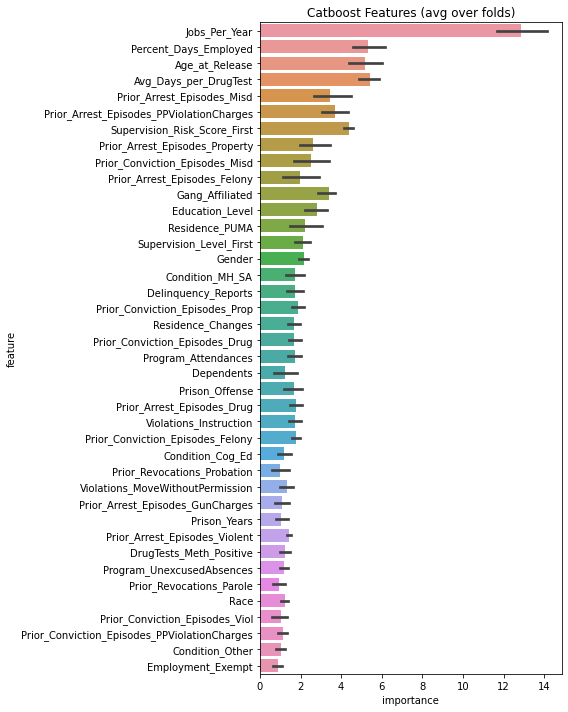

In [44]:
test_5, oof_preds_5 = kfold_lightgbm(X, y, test_df, 5, top_5_params)

0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.19ms	remaining: 15.9s
200:	test: 0.6752821	best: 0.6760052 (186)	total: 493ms	remaining: 11.8s
400:	test: 0.6960923	best: 0.6960923 (400)	total: 1.06s	remaining: 12.1s
600:	test: 0.6977019	best: 0.6989076 (576)	total: 1.56s	remaining: 11.4s
800:	test: 0.6965768	best: 0.6989076 (576)	total: 2.06s	remaining: 10.8s
1000:	test: 0.6967714	best: 0.6989076 (576)	total: 2.56s	remaining: 10.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6989076414
bestIteration = 576

Shrink model to first 577 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.86ms	remaining: 14.3s
200:	test: 0.6397401	best: 0.6436345 (64)	total: 505ms	remaining: 12.1s
400:	test: 0.6507370	best: 0.6508435 (397)	total: 1.05s	remaining: 12.1s
600:	test: 0.6526568	best: 0.6529834 (593)	total: 1.58s	remaining: 11.6s
800:	test: 0.6531633	best: 0.6540314 (772)	total: 2.08s	remaining: 10.9s
1000:	test: 0.6522181	best: 0.6540314 (772)	total: 2.56s	remaini

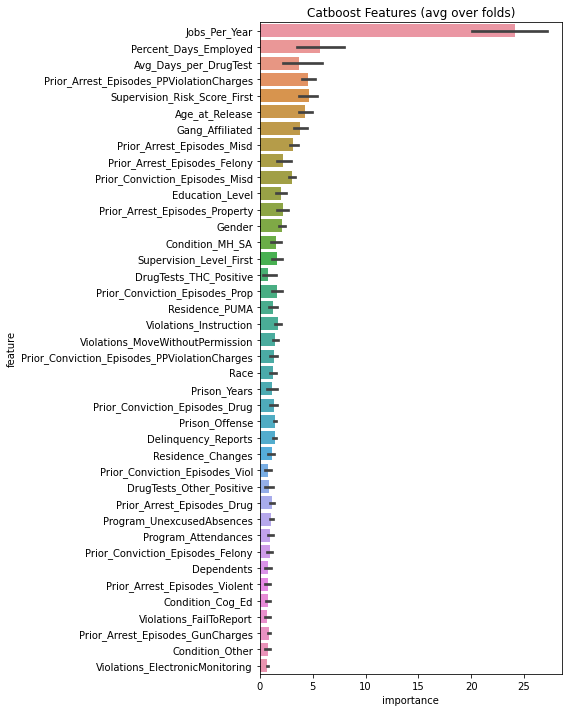

In [45]:
test_4, oof_preds_4 = kfold_lightgbm(X, y, test_df, 5, top_4_params)

0:	test: 0.5828711	best: 0.5828711 (0)	total: 6.09ms	remaining: 30.5s
200:	test: 0.6871068	best: 0.6871343 (199)	total: 803ms	remaining: 19.2s
400:	test: 0.6957968	best: 0.6962630 (397)	total: 1.56s	remaining: 17.9s
600:	test: 0.7025360	best: 0.7035674 (569)	total: 2.46s	remaining: 18s
800:	test: 0.7002401	best: 0.7035674 (569)	total: 3.29s	remaining: 17.3s
1000:	test: 0.6993610	best: 0.7035674 (569)	total: 4.19s	remaining: 16.8s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7035674172
bestIteration = 569

Shrink model to first 570 iterations.
0:	test: 0.5636117	best: 0.5636117 (0)	total: 5.35ms	remaining: 26.8s
200:	test: 0.6383746	best: 0.6406338 (103)	total: 741ms	remaining: 17.7s
400:	test: 0.6476795	best: 0.6476795 (400)	total: 1.6s	remaining: 18.3s
600:	test: 0.6529871	best: 0.6532881 (583)	total: 2.43s	remaining: 17.8s
800:	test: 0.6533119	best: 0.6540809 (763)	total: 3.29s	remaining: 17.2s
1000:	test: 0.6543562	best: 0.6550206 (939)	total: 4.15s	remaining

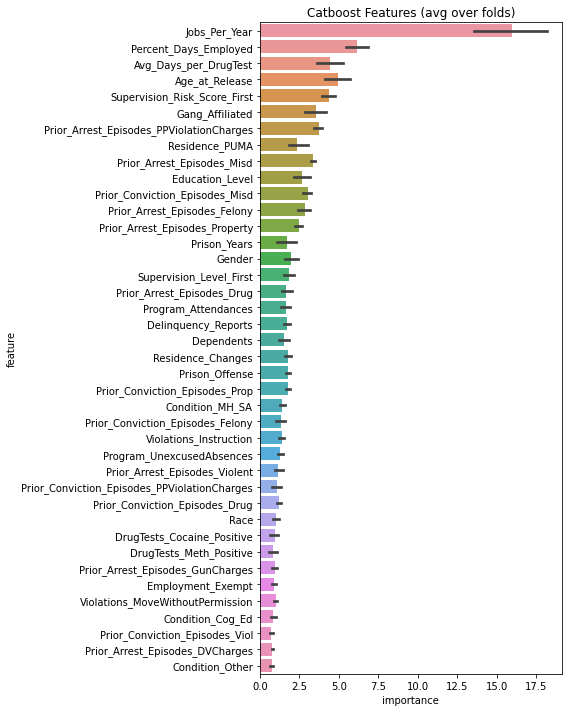

In [46]:
test_3, oof_preds_3 = kfold_lightgbm(X, y, test_df, 5, top_3_params)

0:	test: 0.5730405	best: 0.5730405 (0)	total: 23.9ms	remaining: 1m 59s
200:	test: 0.6883052	best: 0.6891329 (190)	total: 1.51s	remaining: 36.1s
400:	test: 0.6957436	best: 0.6999336 (293)	total: 3.61s	remaining: 41.4s
600:	test: 0.6901277	best: 0.6999336 (293)	total: 5.97s	remaining: 43.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6999335629
bestIteration = 293

Shrink model to first 294 iterations.
0:	test: 0.5609166	best: 0.5609166 (0)	total: 14.6ms	remaining: 1m 13s
200:	test: 0.6411918	best: 0.6412743 (198)	total: 1.4s	remaining: 33.4s
400:	test: 0.6541654	best: 0.6570779 (349)	total: 3.44s	remaining: 39.5s
600:	test: 0.6558391	best: 0.6570779 (349)	total: 5.78s	remaining: 42.3s
800:	test: 0.6533376	best: 0.6570779 (349)	total: 8.03s	remaining: 42.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6570779407
bestIteration = 349

Shrink model to first 350 iterations.
0:	test: 0.5884983	best: 0.5884983 (0)	total: 14.9ms	remaining: 1m 14s

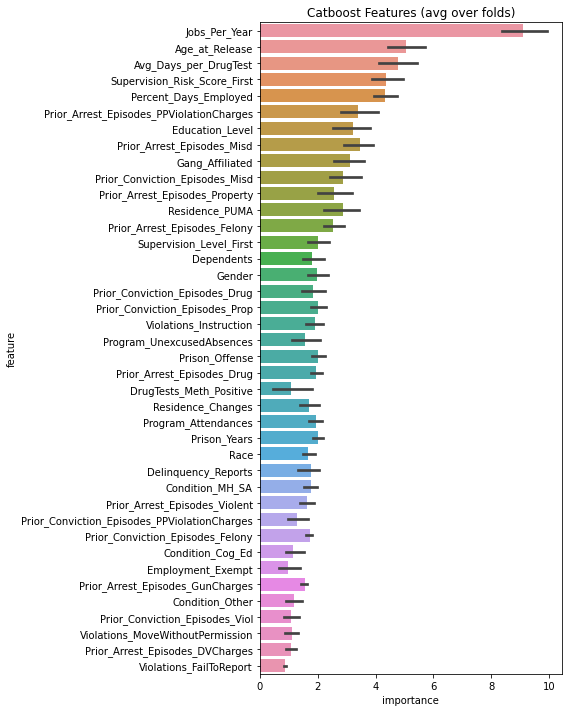

In [47]:
test_2, oof_preds_2 = kfold_lightgbm(X, y, test_df, 5, top_2_params)

0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.05ms	remaining: 15.3s
200:	test: 0.6832454	best: 0.6835243 (198)	total: 572ms	remaining: 13.7s
400:	test: 0.7001630	best: 0.7004364 (395)	total: 1.16s	remaining: 13.3s
600:	test: 0.6994729	best: 0.7026002 (457)	total: 1.73s	remaining: 12.6s
800:	test: 0.6961584	best: 0.7026002 (457)	total: 2.33s	remaining: 12.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7026002246
bestIteration = 457

Shrink model to first 458 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.65ms	remaining: 13.2s
200:	test: 0.6470922	best: 0.6471472 (193)	total: 614ms	remaining: 14.7s
400:	test: 0.6507701	best: 0.6521282 (344)	total: 1.21s	remaining: 13.8s
600:	test: 0.6539671	best: 0.6541745 (532)	total: 1.77s	remaining: 13s
800:	test: 0.6539121	best: 0.6558501 (680)	total: 2.39s	remaining: 12.5s
1000:	test: 0.6550738	best: 0.6558501 (680)	total: 2.97s	remaining: 11.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest 

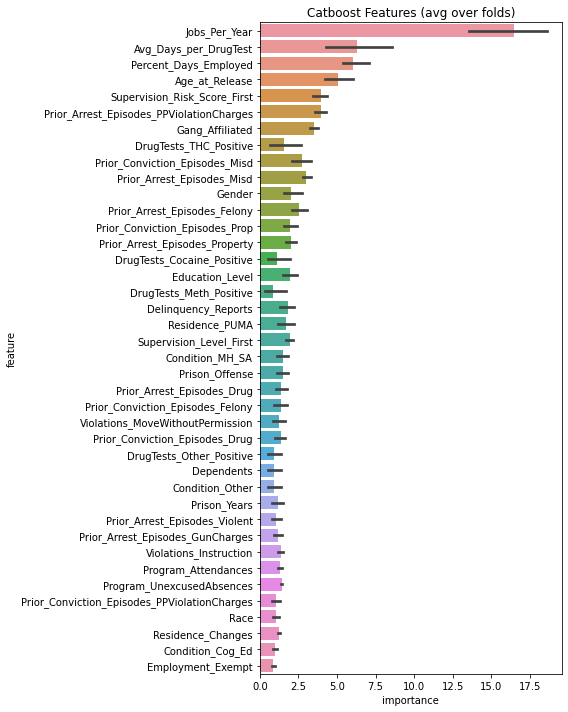

In [48]:
test_1, oof_preds_1 = kfold_lightgbm(X, y, test_df, 5, top_1_params)

In [49]:
cat_train = pd.DataFrame(data={
    "cat_1": oof_preds_1.tolist(),
    "cat_2": oof_preds_2.tolist(),
    "cat_3": oof_preds_3.tolist(),
    "cat_4": oof_preds_4.tolist(),
    "cat_5": oof_preds_5.tolist(),
})
cat_test = pd.DataFrame(data={
    "cat_1": test_1.tolist(),
    "cat_2": test_2.tolist(),
    "cat_3": test_3.tolist(),
    "cat_4": test_4.tolist(),
    "cat_5": test_5.tolist(),
})

In [50]:
cat_train.to_csv('cat_train.csv', index = False)
cat_test.to_csv('cat_test.csv', index = False)